# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
import numpy as np

n_train = y_train.shape[0]

n_test = y_test.shape[0]

image_shape = X_train[0].shape

n_classes = np.unique(y_train).shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

In [3]:
def plot_instance_counts(dataset, name="dataset"):
    from collections import Counter
    counts = Counter(dataset)
    labels, values = zip(*counts.items())
    indexes = np.arange(len(labels))
    width = 0.5
    with plt.style.context(('seaborn-muted')):
        figure = plt.figure(figsize=(15, 3))
        plt.bar(indexes, values, width)
        plt.xticks(indexes + width * 0.5, labels)
        plt.xlabel('Class Label')
        plt.title('{} : Number of instance per class'.format(name))

    plt.show()

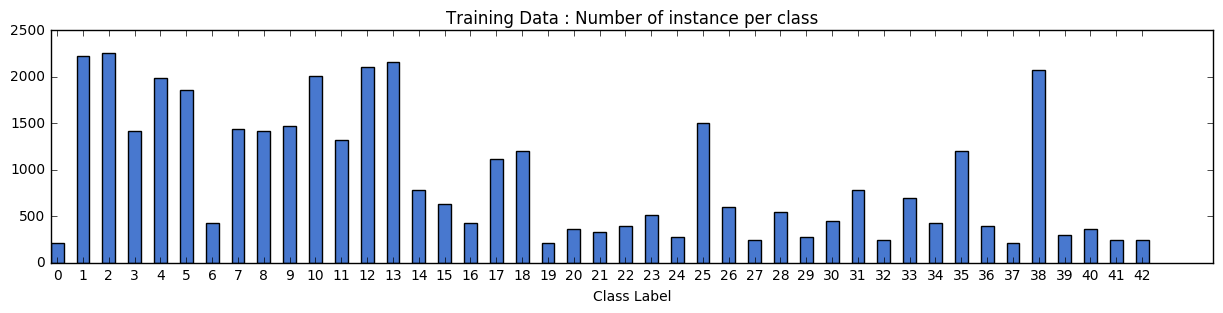

In [5]:
plot_instance_counts(y_train, 'Training Data')

In [4]:
def indices_for_class(class_label, labels=y_train):
    return np.where(labels == [class_label])[0]

def plot_n_images_for_class(class_label, n=4, dataset_source=training_file, labels=y_train, cmap='jet'):
    with open(dataset_source, mode='rb') as f:
        images = pickle.load(f)['features']
        indices = np.random.choice(indices_for_class(class_label), n)
        figure = plt.figure(figsize = (6,6))

        for i, index in enumerate(indices):
            a = figure.add_subplot(n,n, i+1)
            img = plt.imshow(images[index], interpolation='nearest', cmap=cmap)
            plt.axis('off')
        plt.suptitle('images for class {}'.format(class_label))
        plt.show()

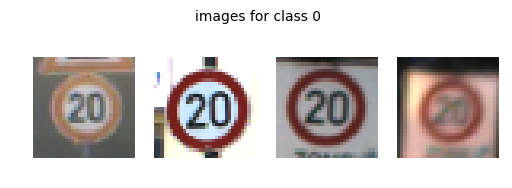

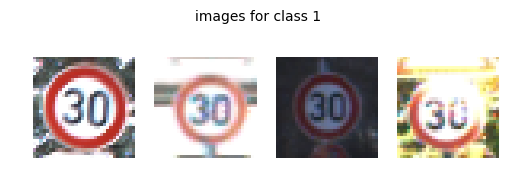

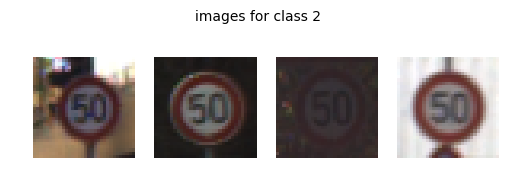

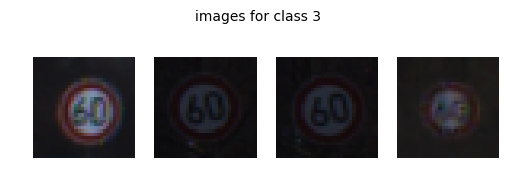

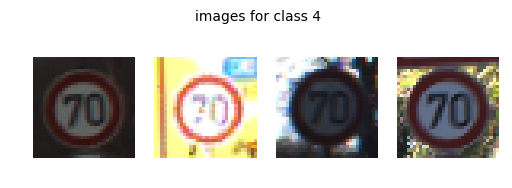

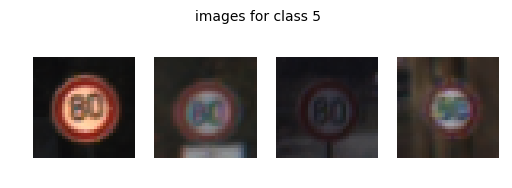

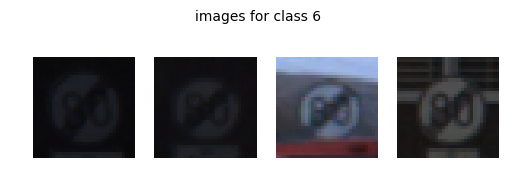

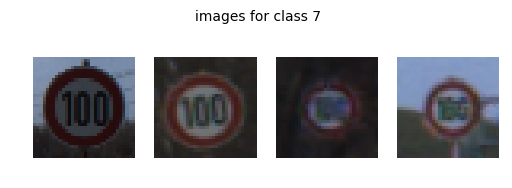

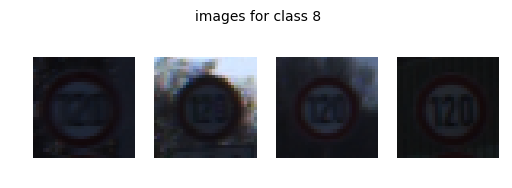

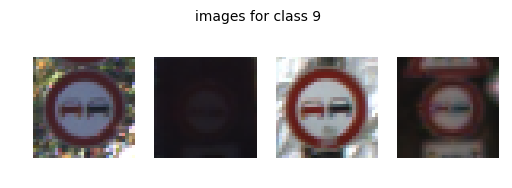

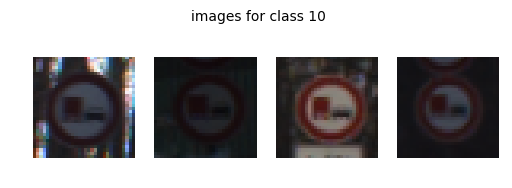

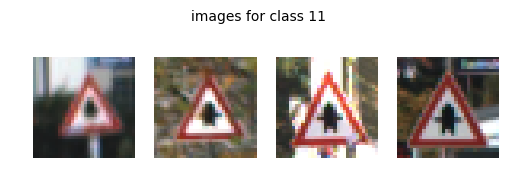

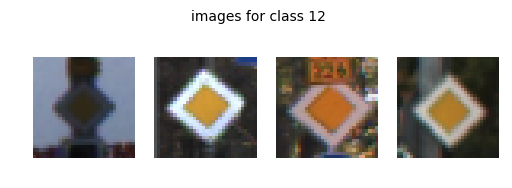

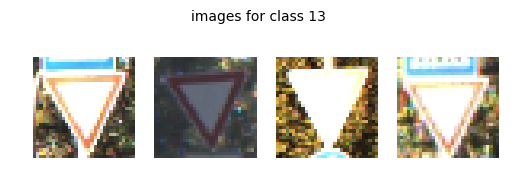

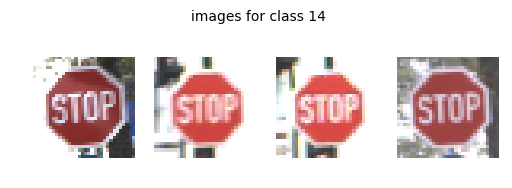

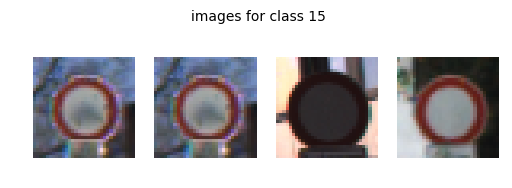

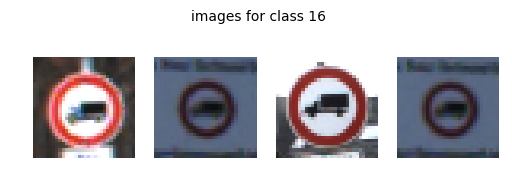

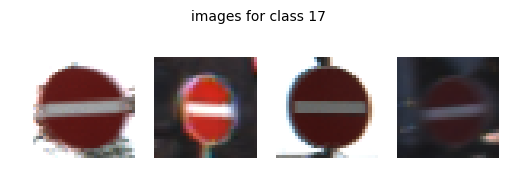

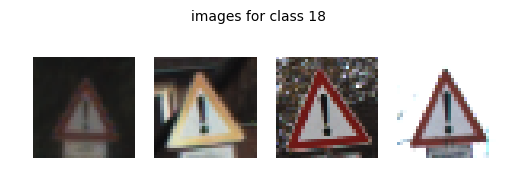

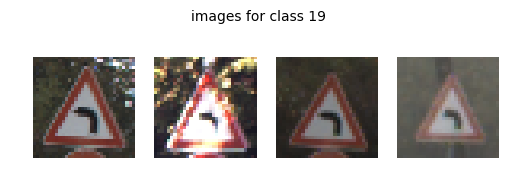

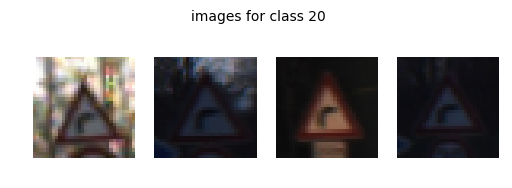

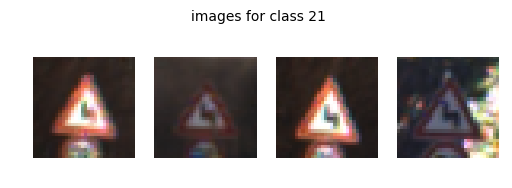

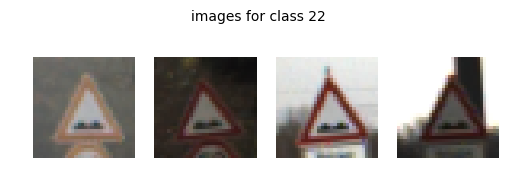

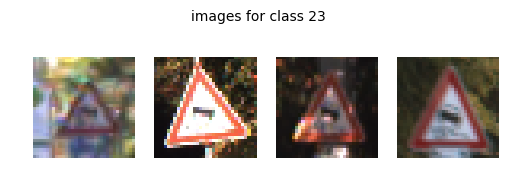

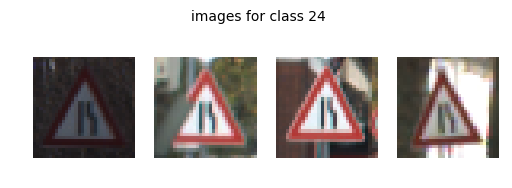

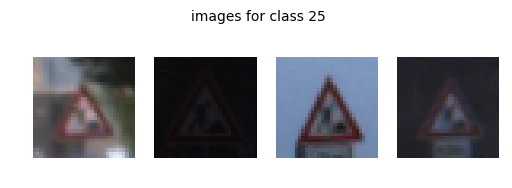

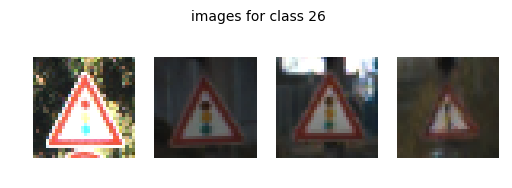

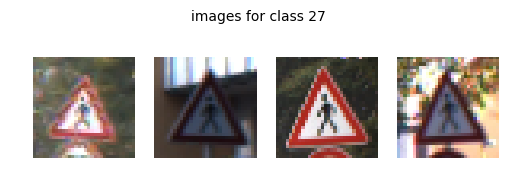

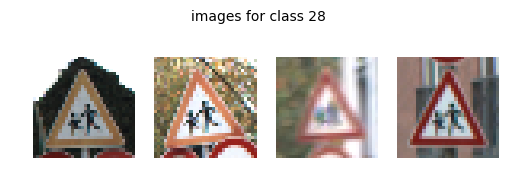

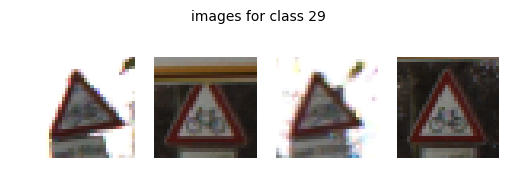

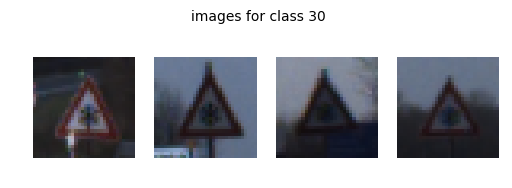

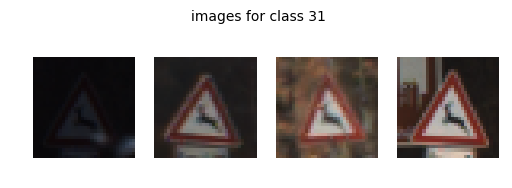

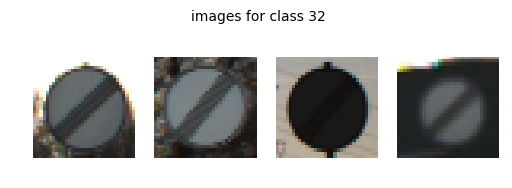

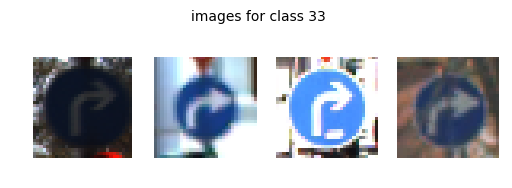

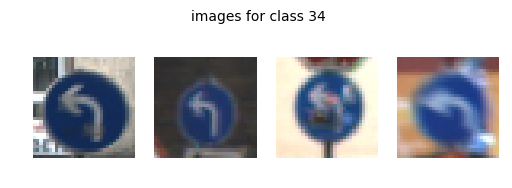

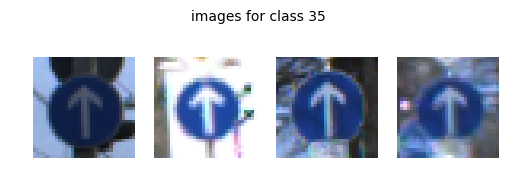

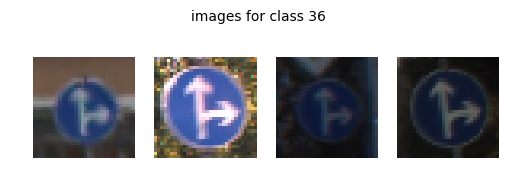

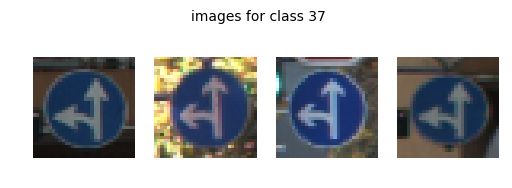

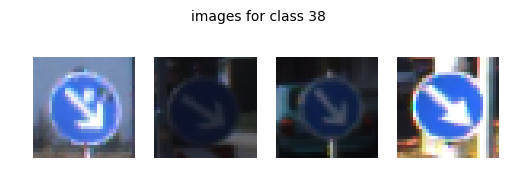

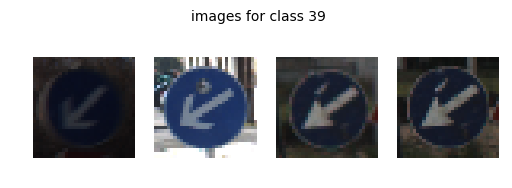

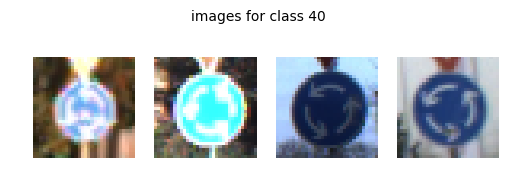

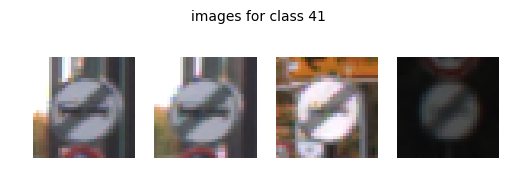

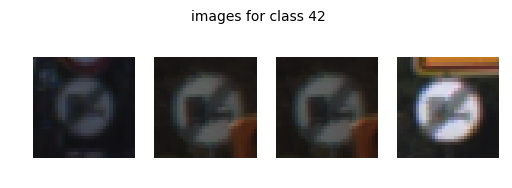

In [7]:
for i in np.arange(43):
    plot_n_images_for_class(i)

In [8]:
# visualizing color distribution accross the images
def plot_color_statistic(image_dataset_file=training_file, name='Dataset', sampling=10):
    with open(image_dataset_file, mode='rb') as f:
        dataset = pickle.load(f)['features']
        n = dataset.shape[0]
        np.random.shuffle(dataset)
        if n < sampling:
            sampling = n
        flattened = []
        for image in dataset[:sampling]:
            flattened.extend(image.flatten())

        std = (np.std(flattened))
        mean = (np.mean(flattened))
        num_bins = 50

        # the histogram of the data
        with plt.style.context(('seaborn-muted')):
            n, bins, patches = plt.hist(flattened, num_bins, normed=1, alpha=0.5)
            plt.xlabel('Color values')
            plt.title(r'Histogram of {} accross {} samples: $\mu={}$, $\sigma={}$'.format(name, sampling ,mean, std))

            # Tweak spacing to prevent clipping of ylabel
            plt.subplots_adjust(left=0.15)
        plt.show()

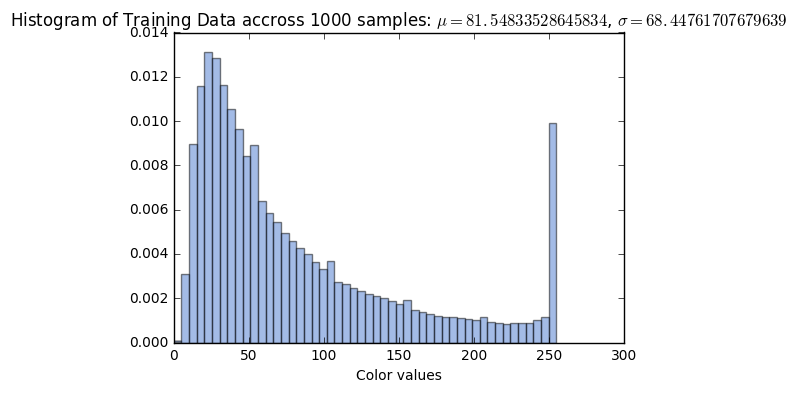

In [9]:
 plot_color_statistic(training_file, "Training Data", 1000)

*** Observations ***
1. We find that there is quite a lot of class imbalance in the dataset; some classes have less than 500 examples while others have more than 2000.
2. After visualizing random sample of images per class of the dataset, we find the following qualities in the images:
    * the size of the signs vary within the same class,
    * there is a slight amount of rotation of the signs in the images, perhaps just a few degrees
    * images of the signs seem to be taken at slightly different angles
    * signs seem to mainly lie near the center of the image
    * the quality of the picture on the interior of the sign varies significantly in terms of quality, sometimes its hard the tell what is inside the image
    * the color of the signs does not seem to be a significant factor in this dataset, each sign seems to be distinguishable based on the shape of the sign board and the shapes inside the sign.

3. By taking a random sample of the images and bucketing the color distribution, we find that the color values are between 0 and 255 with the mode being at approximately 30

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [5]:
### Preprocess the data here.
import cv2
from functools import partial

# convert the image from RGB space to gray scale
def convert_to_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# function that subtracts mean and divides by standard deviation of a dataset for each image
def normalize_and_center(image, std, mean):
    return (image - mean) / std

# function which takes a dataset to create the respective normalization function
def create_normalization_function(image_dataset):
    dataset_mean = np.mean(image_dataset)
    dataset_std = np.std(image_dataset)
    print("dataset mean: {}, std: {}".format(dataset_mean, dataset_std))
    stats_file = 'dataset_stats.p'
    pickle.dump({
            'mean': dataset_mean,
            'std': dataset_std
        }, open(stats_file, 'wb'))
    return partial(normalize_and_center, std=dataset_std, mean=dataset_mean)



In [6]:
# grayscaled data
grayscaled = [convert_to_gray(img) for img in X_train]
# normalizer function based on the data in the training set
normalizer = create_normalization_function(grayscaled)

dataset mean: 81.9003885328464, std: 67.2413617774125


In [12]:
grayscaled_and_centered = np.asarray([normalizer(img) for img in grayscaled])

In [13]:
grayscaled_training = {
    'features' : grayscaled_and_centered
}
grayscale_file = 'gray_training.p'
pickle.dump(grayscaled_training, open(grayscale_file, 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
del grayscaled_training
del grayscaled_and_centered

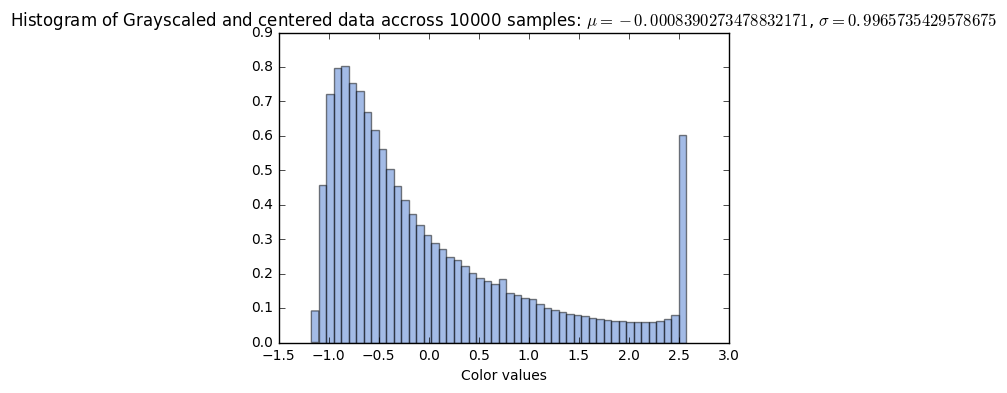

In [14]:
plot_color_statistic(grayscale_file, 'Grayscaled and centered data', 10000)

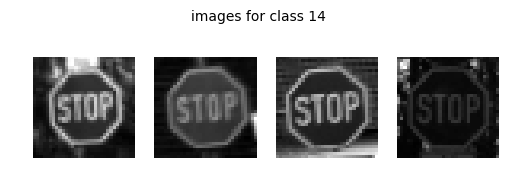

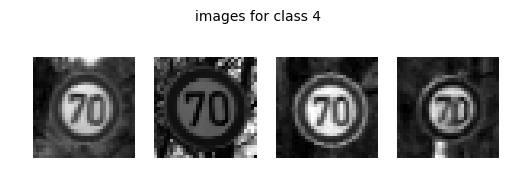

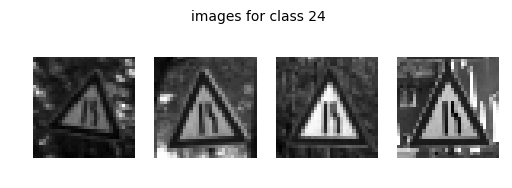

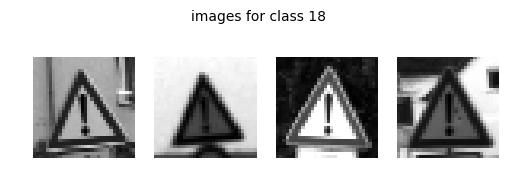

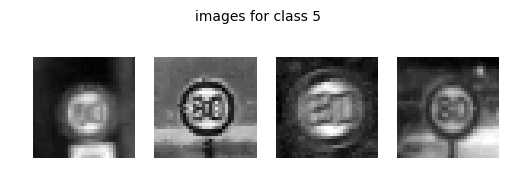

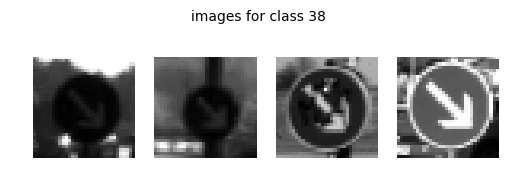

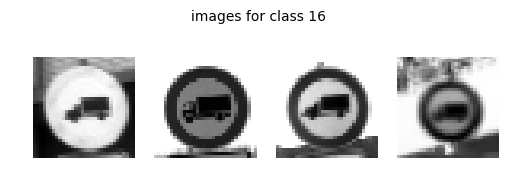

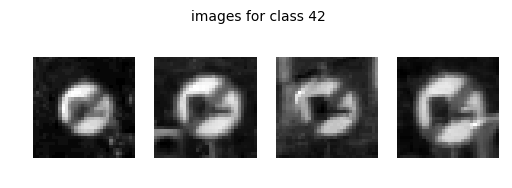

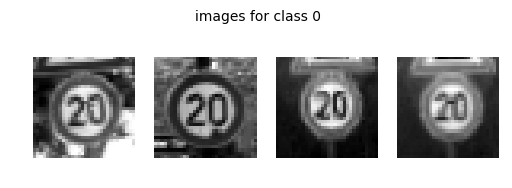

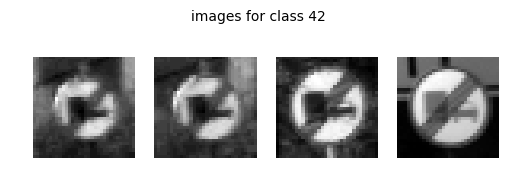

In [15]:
for i in np.random.choice(43, 10):
    plot_n_images_for_class(i, dataset_source=grayscale_file, cmap='gray')

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**
1. since color does not seem like a significant factor based on observing samples of the training set, i decided to use the grayscale channel, to convert the images to grayscale i used the cvtColor function from opencv.

2. I subtracted the mean of the dataset as well normalized the dataset with respect to the training set. To do this, i calculated the standard deviation and mean of the grayscaled training set and used the value to construct a normalizer function which can be applied to individual images. since the color values of the dataset were between 0-255 we subtracted the mean to center the data around 0 and we divided by the standard deviation to keep the values of the dataset in reasonable scale of -1 to 2.5. the same normalization factors are applied on both training and test sets.


In [6]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
import cv2
import math


class ImageTransformer():
    def rotate_image_random(self, image):
        rotation_range = self.rotation_range
        rotation = np.random.uniform(-rotation_range, rotation_range)
        rows, cols = image.shape
        M = cv2.getRotationMatrix2D((cols/2,rows/2),rotation,1)
        dst = cv2.warpAffine(image,M,(cols,rows))
        return dst

    def translate_image_random(self, image):
        translation_range = self.translation_range
        x_translate = np.random.uniform(0, translation_range)
        y_translate = np.random.uniform(0, translation_range)
        rows, cols = image.shape
        M = np.float32([[1,0,x_translate],[0,1,y_translate]])
        dst = cv2.warpAffine(image,M,(cols,rows))
        return dst

    def shear_image_random(self, image):
        shear_factor_range = self.shear_factor_range
        rows, cols = image.shape
        src = np.float32([[0, 0], [0, cols], [rows, cols], [rows, 0]])
        left_edge_perspective = np.random.uniform((1-shear_factor_range)*cols, (1+shear_factor_range)*cols)
        right_edge_perspective = np.random.uniform((1-shear_factor_range)*cols, (1+shear_factor_range)*cols)
        tranform = np.float32([
                [rows-left_edge_perspective, 0],
                [rows-right_edge_perspective, cols],
                [right_edge_perspective, cols],
                [left_edge_perspective, 0]
            ])
        M = cv2.getPerspectiveTransform(src, tranform)
        dst = cv2.warpPerspective(image,M,(rows, cols))
        return dst


    def zoom_image_random(self, image):
        zoom_range = self.zoom_range
        zoom = np.random.uniform(1-zoom_range, 1+zoom_range)
        rows, cols= image.shape
        new_rows = new_cols = math.floor(zoom * rows)
        if zoom < 1:
            # zoom out
            padding = math.ceil(rows - new_rows)
            dst = cv2.copyMakeBorder(image, padding, padding, padding, padding, cv2.BORDER_CONSTANT)
        else:
            # zoom in
            zoomed_image = cv2.resize(image, (new_rows, new_cols))
            crop = math.floor((new_rows - rows) / 2)
            dst = zoomed_image[crop: crop+rows, crop: crop+rows]
        return cv2.resize(dst, (rows, cols)) # ensure size is same as input


    def __init__(self, zoom_range, shear_factor_range, rotation_range, translation_range):
        self.zoom_range = zoom_range
        self.shear_factor_range = shear_factor_range
        self.rotation_range = rotation_range
        self.translation_range = translation_range
        
    def tranform(self, image):
        zoomed = self.zoom_image_random(image)
        sheared = self.shear_image_random(zoomed)
        rotated = self.rotate_image_random(sheared)
        translated = self.translate_image_random(rotated)
        return translated

In [7]:
def batch_generator(arr, batch_size):
    n = len(arr)
    start = range(0, n, batch_size)
    end = range(batch_size, n+batch_size, batch_size)
    for i,j in zip(start, end):
        if j > n:
            yield arr[i:n]
        else:
            yield arr[i:j]

In [18]:
from sklearn.model_selection import train_test_split

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_train_final,X_valid_final, y_train_final, y_valid_final = train_test_split(X_train, y_train, stratify=y_train)

In [19]:
print(X_train_final.shape)
print(X_valid_final.shape)
print(y_train_final.shape)
print(y_valid_final.shape)


(29406, 32, 32, 3)
(9803, 32, 32, 3)
(29406,)
(9803,)


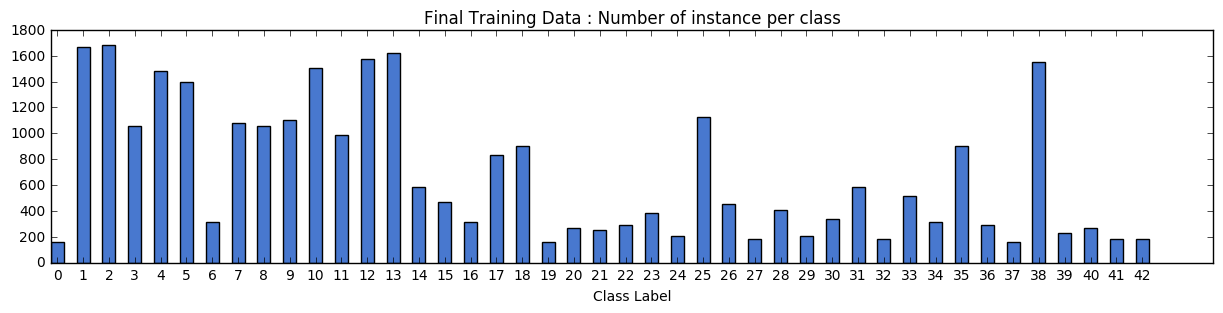

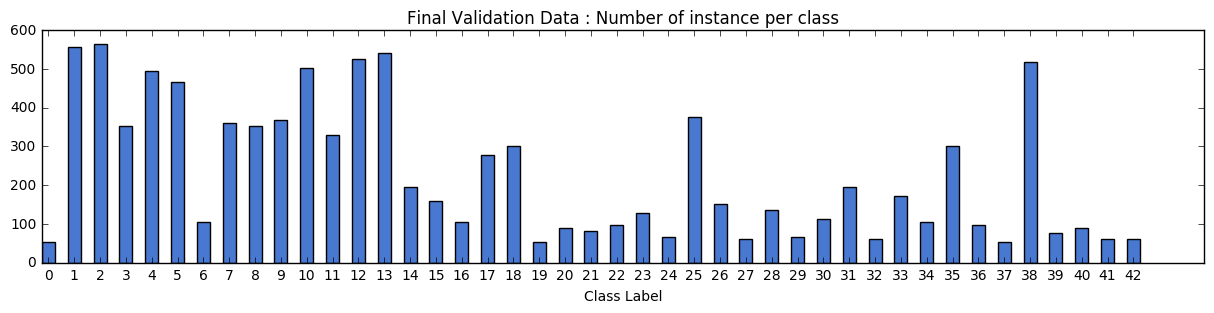

In [20]:
plot_instance_counts(y_train_final, 'Final Training Data')
plot_instance_counts(y_valid_final, 'Final Validation Data')

In [21]:
final_training_file = 'final_training.p'
final_validation_file = 'final_validation.p'
pickle.dump({
            'features': X_train_final,
            'labels': y_train_final
        }, open(final_training_file, 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

pickle.dump({
            'features': X_valid_final,
            'labels': y_valid_final
        }, open(final_validation_file, 'wb'), protocol=pickle.HIGHEST_PROTOCOL)


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

1. training / testing split
I split the training data into 75% training set and 25% validation set and kept the test data as it is. Since there is a class imbalance in the training data, i chose to use the stratify parameter to ensure that the class imbalance is also present in the validation set.

2. data augmentation
instead of generating a large dataset statically , i made a class called image generator which applies a randomized translation, zoom, rotation and shearing for a given image. from the evaluation of the dataset earlier we had found that the images for each class had small amounts of rotations, perspectives, and off center images. This generator helps augment the images of the dataset during runtime to continously generate transformed images, allowing me to train for longer epochs a bit more reliably

In [8]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
from tensorflow.contrib import layers
from tensorflow.contrib.layers import (
    convolution2d, 
    max_pool2d, 
    batch_norm,
    fully_connected,
    xavier_initializer,
    avg_pool2d,
    flatten
)
from tqdm import tqdm
tf.reset_default_graph()

In [9]:
lr = 0.001
sigma = 0.1
hidden = 512
classes= 43
search_epochs = 15
batch_size = 64

In [10]:
def vgg_conv_block(filter_size, inputs):
    k_size = 3
    with (tf.variable_scope("conv_1")):
        conv_1 = convolution2d(
            inputs=inputs,
            num_outputs=filter_size,
            kernel_size=k_size,
            stride=1,
            padding='SAME',
            rate=1,
            activation_fn=tf.nn.relu,
            weights_initializer=tf.truncated_normal_initializer(dtype=tf.float32, stddev=sigma),
            biases_initializer=tf.zeros_initializer,
        )
    with (tf.variable_scope("conv_2")):
        conv_2 = layers.convolution2d(
            inputs=conv_1,
            num_outputs=filter_size,
            kernel_size=k_size,
            stride=1,
            padding='SAME',
            rate=1,
            activation_fn=tf.nn.relu,
            weights_initializer=tf.truncated_normal_initializer(dtype=tf.float32, stddev=sigma),
            biases_initializer=tf.zeros_initializer,
        )
    return max_pool2d(conv_2, [2,2], [2,2], 'SAME')


x = tf.placeholder(tf.float32, (None, 32, 32))
x_reshaped = tf.reshape(x, (-1, 32, 32, 1))
y = tf.placeholder(tf.float32, (None, classes))

#convolutions
with(tf.variable_scope("vgg_block1")):
    vgg_block_1 = vgg_conv_block(32, x_reshaped)
with(tf.variable_scope("vgg_block2")):
    conv_output = vgg_conv_block(64, vgg_block_1)

#fully connected
fc0 = layers.flatten(conv_output)
fc1 = fully_connected(
    inputs=fc0,
    num_outputs=hidden,
    weights_initializer=tf.truncated_normal_initializer(dtype=tf.float32, stddev=sigma),
    biases_initializer=tf.zeros_initializer,
    activation_fn=tf.nn.relu
)
keep_prob= tf.placeholder(tf.float32)
fc_dropout = tf.nn.dropout(fc1, keep_prob=keep_prob)
# classifier_head
y_ = fully_connected(
inputs=fc_dropout,
num_outputs=classes,
weights_initializer=tf.truncated_normal_initializer(dtype=tf.float32, stddev=sigma),
biases_initializer=tf.zeros_initializer,
activation_fn=None
)

# loss, optimizer and training
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(y_, y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = lr)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(y_, 1), tf.argmax(y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
![alt text](CNN.png "Title")


In [11]:
#### defining the preprocessing pipeline
import pickle
from functools import partial
import numpy as np
stats_file = 'dataset_stats.p'
with open(stats_file, mode='rb') as f:
    stats = pickle.load(f)
    
augmentation_generator = ImageTransformer(0.2, 0.3, 30, 5)
normalizing_function = partial(normalize_and_center,stats['std'], stats['mean'])

def preprocess_image(image):
    return normalizing_function(
            convert_to_gray(
                image
        ))

def augment_and_preprocess(image, augmentation_generator=augmentation_generator):
    choice = np.random.choice([0,1])
    if choice == 1:
        return augmentation_generator.tranform(
            preprocess_image(image)
        )
    else:
        return preprocess_image(image)

from sklearn.preprocessing import OneHotEncoder
label_encoder = OneHotEncoder()
label_encoder.fit(np.arange(classes).reshape(-1,1))

def encode_label(y):
    return label_encoder.transform(y).toarray()[0]


def shuffle_dataset(features, labels):
    perm = np.arange(labels.shape[0])
    np.random.shuffle(perm)
    features = features[perm]
    labels = labels[perm]
    return features, labels


In [12]:
### Train your model here.
### Feel free to use as many code cells as needed.

# evaluation function
def eval_data(dataset_features, dataset_labels, batch_size=batch_size):
        total_acc, total_loss = 0, 0
        num_examples = len(dataset_labels)
        sess = tf.get_default_session()
        dataset_feature_batcher = batch_generator(dataset_features, batch_size)
        dataset_label_batcher = batch_generator(dataset_labels, batch_size)
        for batch_x in dataset_feature_batcher:
            batch_size = len(batch_x)
            batch_y = next(dataset_label_batcher)
            batch_y = [encode_label(y) for y in batch_y]
            batch_x = [augment_and_preprocess(image) for image in batch_x]
            loss, acc = sess.run([loss_operation, accuracy_operation], feed_dict={
                    x: batch_x, 
                    y: batch_y,
                    keep_prob: 1
                    
                })
            total_acc += (acc * batch_size)
            total_loss += (loss * batch_size)
        return total_loss/num_examples, total_acc/num_examples

In [13]:
# load the training, validation, test sets
final_training_file = 'final_training.p'
final_validation_file = 'final_validation.p'
final_testing_file = 'test.p'

with open(final_training_file, mode='rb') as f:
    train = pickle.load(f)
with open(final_validation_file, mode='rb') as f:
    validation = pickle.load(f)
with open(final_testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = validation['features'], validation['labels']
X_test, y_test = test['features'], test['labels']

In [80]:
save_file = 'models/model'
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(search_epochs):
        X_train, y_train = shuffle_dataset(X_train, y_train)
        preprocessed_X_train = np.asarray([augment_and_preprocess(image) for image in X_train])
        prepocessed_X_valid = np.asarray([augment_and_preprocess(image) for image in X_valid])
        train_feature_batcher = batch_generator(preprocessed_X_train, batch_size)
        train_label_batcher = batch_generator(y_train, batch_size)
        n = 0
        train_accuracy_total = 0
        training_loss_total = 0
        for x_batch in tqdm(
            train_feature_batcher, 
            unit='batches', 
            total=X_train.shape[0]/ batch_size):
            actual_batch_size = len(x_batch)
            y_batch = next(train_label_batcher)
            y_batch = [encode_label(y) for y in y_batch]


            result, training_loss, training_accuracy=sess.run([training_operation, loss_operation, accuracy_operation], feed_dict={
                    x: x_batch,
                    y: y_batch,
                    keep_prob: 0.5
            })
            train_accuracy_total += (training_accuracy * actual_batch_size)
            training_loss_total += (training_loss * actual_batch_size)

            n += 1
        val_loss, val_acc = eval_data(X_valid, y_valid)
        train_losses.append(training_loss_total/X_train.shape[0])
        train_accuracies.append(train_accuracy_total/X_train.shape[0])
        test_losses.append(val_loss)
        test_accuracies.append(val_acc)
    saver.save(sess, save_file)
    results_training = {}
    results_training['final_model'] = {}
    results_training['final_model']['train_loss'] = train_losses
    results_training['final_model']['train_acc'] = train_accuracies
    results_training['final_model']['test_loss'] = test_losses
    results_training['final_model']['test_acc'] = test_accuracies

460batches [04:24,  2.19batches/s]                          
460batches [05:43,  1.76batches/s]                          
460batches [05:31,  2.11batches/s]                          
460batches [1:27:04, 11.36s/batches]                          
460batches [-1:59:34, -0.06s/batches]                       
460batches [04:10,  2.28batches/s]                          
460batches [04:10,  1.89batches/s]                          
460batches [04:01,  2.24batches/s]                          
460batches [04:40,  2.00batches/s]                          
460batches [05:04,  2.30batches/s]                          
460batches [04:21,  2.33batches/s]                          
460batches [04:19,  2.27batches/s]                          
460batches [04:15,  2.22batches/s]                          
460batches [04:11,  2.21batches/s]                          
460batches [04:21,  2.28batches/s]                          


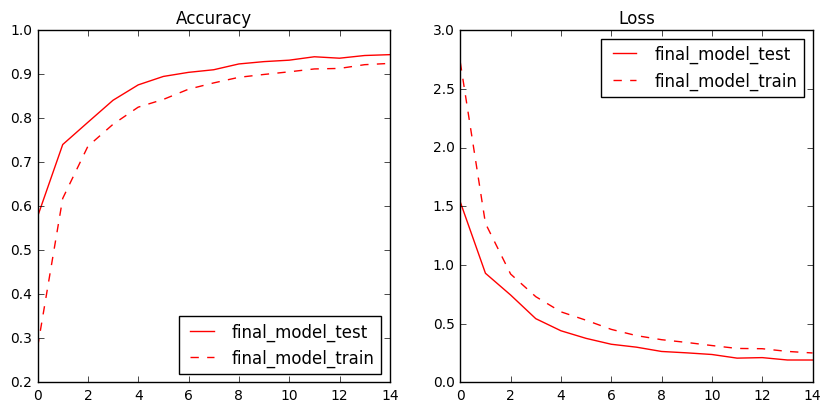

In [81]:
plot_results(results_training, colors={'final_model': 'r'})

In [14]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./models/'))
    X_test = np.asarray([preprocess_image(image) for image in X_test])
    train_feature_batcher = batch_generator(X_test, batch_size)
    train_label_batcher = batch_generator(y_test, batch_size)
    total_accuracy = 0
    total_loss = 0
    for x_batch in tqdm(
        train_feature_batcher, 
        unit='batches', 
        total=X_test.shape[0]/ batch_size):
        actual_batch_size = len(x_batch)
        y_batch = next(train_label_batcher)
        y_batch = [encode_label(y) for y in y_batch]
        test_batch_loss, test_batch_accuracy=sess.run([ loss_operation, accuracy_operation], feed_dict={
                x: x_batch,
                y: y_batch,
                keep_prob: 0.5
        })
        total_accuracy += (test_batch_accuracy * actual_batch_size)
        total_loss += (test_batch_loss * actual_batch_size)
    
    print("test accuracy {}".format(total_accuracy/ X_test.shape[0]))
    print("test loss {}".format(total_loss/ X_test.shape[0]))
    

198batches [01:12,  2.45batches/s]                          

test accuracy 0.9603325416148889
test loss 0.20552792116521798


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

Based on the analysis I did for determining hyperparameters for the model as described the next section, i determined that the optimal parameters for the network to be

batch_size = 64
learning_rate = 0.001
standard deviation for weight initialization = 0.1
number of hidden_nodes = 512
dropout for fully connected layers = 0.5

the steps for the analysis are discussed in the next section along with network design.
I trained the network for 15 epochs with augmentation of the dataset randomly on each epoch. 

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

*** Answer : ***
To determine a suitable model, we have quite a lot of questions to ask:
    1. which convolution architecture is suitable for the problem at hand ?
    2. what is the ideal initialization space ?
    3. what are the useful regularization techniques ?


Doing a parameter search accross all the parameters on the entire dataset did not seem like a feasable idea given the size of the dataset. To be able to do rapid iterations and converge on a model i think is suitable i decided to create a smaller dataset with only 2 classes and change thise problem into a binary classifier problem. 
This seemed like a good idea since:
* the dataset will be a fraction of the size (5000 images) allowing for fast experiments. 
* the main challenge of the problem is dimensionality reduction from 784 features to a suitable representation and thus solving the binary classification problem should generalize to the multiclass classification problem of our dataset. 

The two classes i selected were class 2 and class 11. class 2 are the circular "Speed limit (50km/h)" and class 11 are the triangular "Right-of-way at the next intersection". I chose these classes because there are around 2000+ images for each of these classes so the dataset is balanced and there is a good enough distinction between the circular and triangular signs to be able to do the binary classification.

using this binary dataset i also set up the benchmark of  just predicting everything as class 2.

In [25]:
class_2_indices = indices_for_class(2)
class_2_images = X_train[class_2_indices]
class_13_indices = indices_for_class(13)
class_13_images = X_train[class_13_indices]

In [26]:
binary_X = np.vstack([class_2_images,class_13_images])
# grayscaled data
grayscaled_binary = [convert_to_gray(img) for img in binary_X]
# normalizer function based on the data in the training set
binary_normalizer = create_normalization_function(grayscaled_binary)
binary_X = [binary_normalizer(img) for img in grayscaled_binary]

a = np.zeros([len(class_13_images),1])
b = np.ones([len(class_2_images),1])
binary_y = np.vstack([a,b])
binary_y= binary_y.reshape(binary_y.shape[0])

dataset mean: 95.87458523774093, std: 70.65047259386454


In [27]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(binary_X, binary_y)

In [ ]:
binary_file = 'binary.p'
binary = {
    'train_X' : np.asarray(train_X) ,
    'train_y': np.asarray(train_y),
    'test_X': np.asarray(test_X),
    'test_y': np.asarray(test_y),
}

pickle.dump(binary, open(binary_file, 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

In [29]:
from sklearn.metrics import accuracy_score
benchmark = accuracy_score(binary_y, np.ones(len(binary_y)))
print("Benchmark for predicting all in class 2: {}".format(benchmark))

Benchmark for predicting all in class 2: 0.5102040816326531


with our simplified dataset constructed and some basic benchmark set we have a good starting point to start architecture planning. Instead of constructing each architecture from scratch i decided to reference 3 populaar network architectures and create a simplified implmentation of each:
    1. LeNet (Hierarchial pyramid structure)
    2. VggNet (stacks Small convolution filters)
    3. Inception (concatenation of multi sized convolution filters)

I set the all the other parameters to a constant and compare the three models on a small number of epochs.

In [13]:
lr = 0.001
sigma = 0.1
hidden = 1024
classes= 2
search_epochs = 5

In [14]:
from sklearn.preprocessing import OneHotEncoder
binary_label_encoder = OneHotEncoder()
binary_label_encoder.fit(np.arange(classes).reshape(-1,1))

def binary_encode_label(y):
    return binary_label_encoder.transform(y).toarray()[0]

In [15]:
def graph_setup(model):
    #inputs 
    x = tf.placeholder(tf.float32)
    x_reshaped = tf.reshape(x, (-1, 32, 32, 1))
    y = tf.placeholder(tf.float32)
    
    #convolutions
    conv_output = model(x_reshaped)
    
    #fully connected
    fc0 = layers.flatten(conv_output)
    fc1 = fully_connected(
        inputs=fc0,
        num_outputs=hidden,
        weights_initializer=tf.truncated_normal_initializer(dtype=tf.float32, stddev=sigma),
        biases_initializer=tf.zeros_initializer,
        activation_fn=tf.nn.relu
    )
    
    # classifier_head
    y_ = fully_connected(
    inputs=fc1,
    num_outputs=classes,
    weights_initializer=tf.truncated_normal_initializer(dtype=tf.float32, stddev=sigma),
    biases_initializer=tf.zeros_initializer,
    activation_fn=None
    )
    
    # loss, optimizer and training
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(y_, y)
    loss_operation = tf.reduce_mean(cross_entropy)
    optimizer = tf.train.AdamOptimizer(learning_rate = lr)
    training_operation = optimizer.minimize(loss_operation)
    
    correct_prediction = tf.equal(tf.argmax(y_, 1), tf.argmax(y, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    return x , x_reshaped, y, conv_output, fc0, fc1, y_, cross_entropy, loss_operation, optimizer, training_operation, correct_prediction, accuracy_operation


In [16]:
def vgg_conv_block(filter_size, inputs):
    k_size = 3
    with (tf.variable_scope("conv_1")):
        conv_1 = convolution2d(
            inputs=inputs,
            num_outputs=filter_size,
            kernel_size=k_size,
            stride=1,
            padding='SAME',
            rate=1,
            activation_fn=tf.nn.relu,
            weights_initializer=tf.truncated_normal_initializer(dtype=tf.float32, stddev=sigma),
            biases_initializer=tf.zeros_initializer,
        )
    with (tf.variable_scope("conv_2")):
        conv_2 = layers.convolution2d(
            inputs=conv_1,
            num_outputs=filter_size,
            kernel_size=k_size,
            stride=1,
            padding='SAME',
            rate=1,
            activation_fn=tf.nn.relu,
            weights_initializer=tf.truncated_normal_initializer(dtype=tf.float32, stddev=sigma),
            biases_initializer=tf.zeros_initializer,
        )
    return max_pool2d(conv_2, [2,2], [2,2], 'SAME')

In [17]:
def inception_module(inputs, filter_size):
    conv_1x = convolution2d(
        inputs=inputs,
        num_outputs=filter_size,
        kernel_size=1,
        stride=1,
        padding='SAME',
        rate=1,
        activation_fn=tf.nn.relu,
        weights_initializer=tf.truncated_normal_initializer(dtype=tf.float32, stddev=sigma),
        biases_initializer=tf.zeros_initializer,
    )
    conv_3x = convolution2d(
        inputs=inputs,
        num_outputs=filter_size,
        kernel_size=3,
        stride=1,
        padding='SAME',
        rate=1,
        activation_fn=tf.nn.relu,
        weights_initializer=tf.truncated_normal_initializer(dtype=tf.float32, stddev=sigma),
        biases_initializer=tf.zeros_initializer,
    )
    conv_5x = convolution2d(
        inputs=inputs,
        num_outputs=filter_size,
        kernel_size=5,
        stride=1,
        padding='SAME',
        rate=1,
        activation_fn=tf.nn.relu,
        weights_initializer=tf.truncated_normal_initializer(dtype=tf.float32, stddev=sigma),
        biases_initializer=tf.zeros_initializer,
    )
    max_pool_input= max_pool2d(inputs, [3,3], [3,3], 'SAME')
    
    concatenated_filter = tf.concat(3, [conv_1x, conv_3x, conv_5x])
    return tf.nn.relu(concatenated_filter)


In [18]:
def model_a(x):
    # LeNet Architecture
    conv_1 = convolution2d(
        inputs=x,
        num_outputs=6,
        kernel_size=5,
        stride=1,
        padding='VALID',
        rate=1,
        activation_fn=tf.nn.relu,
        weights_initializer=tf.truncated_normal_initializer(dtype=tf.float32, stddev=sigma),
        biases_initializer=tf.zeros_initializer,
    )
    max_pool_1 = max_pool2d(conv_1, [2,2], [2,2], 'VALID')
    conv_2 = convolution2d(
        inputs=max_pool_1,
        num_outputs=16,
        kernel_size=5,
        stride=1,
        padding='VALID',
        rate=1,
        activation_fn=tf.nn.relu,
        weights_initializer=tf.truncated_normal_initializer(dtype=tf.float32, stddev=sigma),
        biases_initializer=tf.zeros_initializer,
    )
    max_pool_2 = max_pool2d(conv_2, [2,2], [2,2], 'VALID')
    return max_pool_2

def model_b(x):
    # VggNet Architecture
    with(tf.variable_scope("vgg_block1")):
        vgg_block_1 = vgg_conv_block(32, x)
    with(tf.variable_scope("vgg_block2")):
        vgg_block_2 = vgg_conv_block(64, vgg_block_1)
    return vgg_block_2

def model_c(x):
    #Inception architecture
    with(tf.variable_scope("inception_block_1")):
         inception1 = inception_module(x, 32)
    with(tf.variable_scope("inception_block_2")):
         inception2 = inception_module(inception1, 32)
    
    return inception2
    

In [19]:
binary_file = 'binary.p'
with open(binary_file, mode='rb') as f:
    dataset = pickle.load(f)
    
train_X = dataset['train_X']
train_y = dataset['train_y']
test_X = dataset['test_X']
test_y = dataset['test_y']

In [20]:
batch_size = 64
results = {}

models = [model_c, model_a, model_b]
for model in models:
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    tf.reset_default_graph()
    with tf.Session() as sess:
        # setup tf graph
        (x , 
         x_reshaped, 
         y, 
         conv_output, 
         fc0, 
         fc1, 
         y_, 
         cross_entropy, 
         loss_operation,
         optimizer, 
         training_operation, 
         correct_prediction, 
         accuracy_operation) = graph_setup(model)

        # setup evaluation function
        def eval_data(dataset_features, dataset_labels, batch_size=batch_size):
            total_acc, total_loss = 0, 0
            num_examples = len(dataset_labels)
            sess = tf.get_default_session()
            dataset_feature_batcher = batch_generator(dataset_features, batch_size)
            dataset_label_batcher = batch_generator(dataset_labels, batch_size)
            for batch_x in dataset_feature_batcher:
                batch_size = len(batch_x)
                batch_y = next(dataset_label_batcher)
                batch_y = [binary_encode_label(y) for y in batch_y]
                loss, acc = sess.run([loss_operation, accuracy_operation], feed_dict={
                        x: batch_x, 
                        y: batch_y,
                    })
                total_acc += (acc * batch_size)
                total_loss += (loss * batch_size)
            return total_loss/num_examples, total_acc/num_examples

        sess.run(tf.global_variables_initializer())
        for i in range(search_epochs):
            train_X, train_y = shuffle_dataset(train_X, train_y)
            train_feature_batcher = batch_generator(train_X, batch_size)
            train_label_batcher = batch_generator(train_y, batch_size)
            n = 0
            train_accuracy_total = 0
            training_loss_total = 0
            for x_batch in tqdm(
                train_feature_batcher, 
                unit='batches', 
                total=train_X.shape[0]/ batch_size):

                y_batch = next(train_label_batcher)
                y_batch = [binary_encode_label(y) for y in y_batch]


                result, training_loss, training_accuracy=sess.run([training_operation, loss_operation, accuracy_operation], feed_dict={
                        x: x_batch,
                        y: y_batch,
                })
                train_accuracy_total += (training_accuracy * batch_size)
                training_loss_total += (training_loss * batch_size)

                n += 1
            val_loss, val_acc = eval_data(test_X, test_y)
            train_losses.append(training_loss_total/train_X.shape[0])
            train_accuracies.append(train_accuracy_total/train_X.shape[0])
            test_losses.append(val_loss)
            test_accuracies.append(val_acc)
    
    print("finished a model")
    if model == model_a:
        m_name = 'lenet'
    if model == model_b:
        m_name = 'vgg'
    if model == model_c:
        m_name = 'inception'
    
    results[m_name] = {}
    results[m_name]['train_loss'] = train_losses
    results[m_name]['train_acc'] = train_accuracies
    results[m_name]['test_loss'] = test_losses
    results[m_name]['test_acc'] = test_accuracies


52batches [08:23,  6.42s/batches]                          
52batches [06:33,  6.48s/batches]                          
52batches [06:17,  6.24s/batches]                          
52batches [06:12,  6.73s/batches]                          
52batches [06:55,  6.01s/batches]                          


finished a model


52batches [00:05,  9.34batches/s]                          
52batches [00:05,  7.06batches/s]                          
52batches [00:04, 11.44batches/s]                          
52batches [00:05, 11.44batches/s]                          
52batches [00:04, 10.66batches/s]                          


finished a model


52batches [00:29,  2.02batches/s]                          
52batches [00:29,  1.81batches/s]                          
52batches [00:28,  2.01batches/s]                          
52batches [00:28,  1.99batches/s]                          
52batches [00:28,  1.99batches/s]                          


finished a model


In [21]:
def plot_results(results, colors={'lenet': 'r', 'vgg': 'g', 'inception': 'b'}):
    fig = plt.figure(figsize=(10, 10))
    accuracy_graph = fig.add_subplot(2,2,1)
    models = results.keys()
    
    for k in models:
        accuracy_graph.plot(results[k]['test_acc'], color=colors[k], linestyle='solid', label=k+'_test')
        accuracy_graph.plot(results[k]['train_acc'], color=colors[k],linestyle='dashed',label=k+'_train')
    accuracy_graph.legend(loc='lower right')
    accuracy_graph.set_title("Accuracy")
    loss_graph = fig.add_subplot(2,2,2)
    for k in models:
        loss_graph.plot(results[k]['test_loss'], color=colors[k], linestyle='solid', label=k+'_test')
        loss_graph.plot(results[k]['train_loss'], color=colors[k],linestyle='dashed', label=k+'_train')
    loss_graph.legend(loc='upper right')
    loss_graph.set_title("Loss")

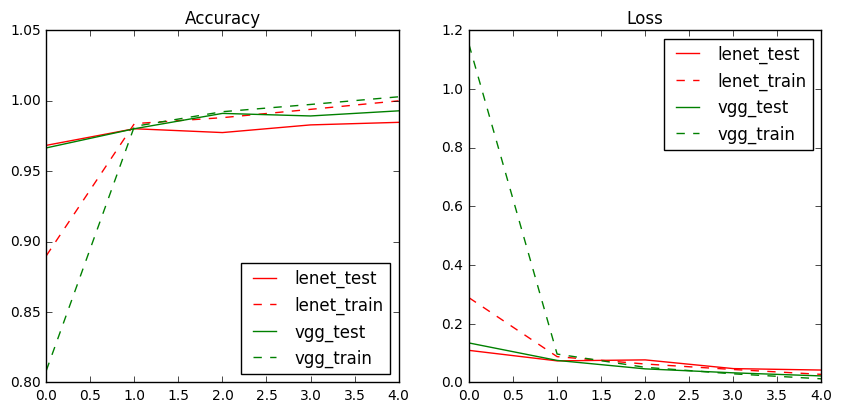

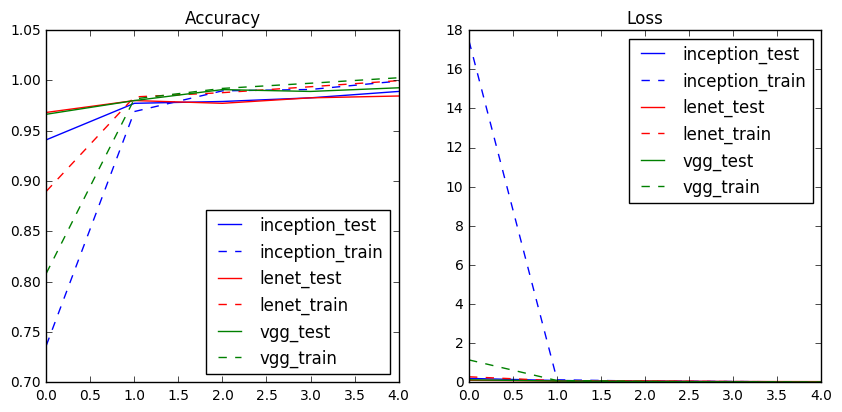

In [25]:
res = {
    'lenet': results['lenet'],
    'vgg': results['vgg']
}
plot_results(res)
plot_results(results)

From the graphs plotted we can see that vggnet performs better than the other architectures on the binary classification problem.
It acheives the highest accuracy in both the training and the test sets and seems to be converging fastest on the loss function.
All the networks explored seem to be overfitting quite fast, for this reason after determining an architecture for the problem i decided to explore regulazitation techniques such as dropout as well as hyperparameter search on learning rates, batch size etc.

In [26]:
def param_search_graph_setup(lr, hidden_nodes, sigma):
    #inputs 
    x = tf.placeholder(tf.float32)
    x_reshaped = tf.reshape(x, (-1, 32, 32, 1))
    y = tf.placeholder(tf.float32)
    
    #convolutions
    conv_output = model_b(x_reshaped)
    
    #fully connected
    fc0 = layers.flatten(conv_output)
    fc1 = fully_connected(
        inputs=fc0,
        num_outputs=hidden_nodes,
        weights_initializer=tf.truncated_normal_initializer(dtype=tf.float32, stddev=sigma),
        biases_initializer=tf.zeros_initializer,
        activation_fn=tf.nn.relu
    )
    keep_prob= tf.placeholder(tf.float32)
    fc_dropout = tf.nn.dropout(fc1, keep_prob=keep_prob)
    # classifier_head
    y_ = fully_connected(
    inputs=fc_dropout,
    num_outputs=classes,
    weights_initializer=tf.truncated_normal_initializer(dtype=tf.float32, stddev=sigma),
    biases_initializer=tf.zeros_initializer,
    activation_fn=None
    )
    
    # loss, optimizer and training
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(y_, y)
    loss_operation = tf.reduce_mean(cross_entropy)
    optimizer = tf.train.AdamOptimizer(learning_rate = lr)
    training_operation = optimizer.minimize(loss_operation)
    
    correct_prediction = tf.equal(tf.argmax(y_, 1), tf.argmax(y, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    return x , x_reshaped, y, conv_output, fc0, keep_prob, fc1, y_, cross_entropy, loss_operation, optimizer, training_operation, correct_prediction, accuracy_operation


##### learning rate exploration

In [27]:
learning_rates = [0.1, 0.01, 0.001]
sigma = 0.1
hidden_nodes = 1024
classes= 2
search_epochs = 5
batch_size = 64
results_lr = {}

for lr in learning_rates:
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    tf.reset_default_graph()
    with tf.Session() as sess:
        # setup tf graph
        (x , 
         x_reshaped, 
         y, 
         conv_output, 
         fc0,
         keep_prob,
         fc1, 
         y_, 
         cross_entropy, 
         loss_operation,
         optimizer, 
         training_operation, 
         correct_prediction, 
         accuracy_operation) = param_search_graph_setup(lr, hidden_nodes, sigma)

        # setup evaluation function
        def eval_data(dataset_features, dataset_labels, batch_size=batch_size):
            total_acc, total_loss = 0, 0
            num_examples = len(dataset_labels)
            sess = tf.get_default_session()
            dataset_feature_batcher = batch_generator(dataset_features, batch_size)
            dataset_label_batcher = batch_generator(dataset_labels, batch_size)
            for batch_x in dataset_feature_batcher:
                batch_size = len(batch_x)
                batch_y = next(dataset_label_batcher)
                batch_y = [binary_encode_label(y) for y in batch_y]
                loss, acc = sess.run([loss_operation, accuracy_operation], feed_dict={
                        x: batch_x, 
                        y: batch_y,
                        keep_prob: 1,
                    })
                total_acc += (acc * batch_size)
                total_loss += (loss * batch_size)
            return total_loss/num_examples, total_acc/num_examples

        sess.run(tf.global_variables_initializer())
        for i in range(search_epochs):
            train_X, train_y = shuffle_dataset(train_X, train_y)
            train_feature_batcher = batch_generator(train_X, batch_size)
            train_label_batcher = batch_generator(train_y, batch_size)
            n = 0
            train_accuracy_total = 0
            training_loss_total = 0
            for x_batch in tqdm(
                train_feature_batcher, 
                unit='batches', 
                total=train_X.shape[0]/ batch_size):

                y_batch = next(train_label_batcher)
                y_batch = [binary_encode_label(y) for y in y_batch]


                result, training_loss, training_accuracy=sess.run([training_operation, loss_operation, accuracy_operation], feed_dict={
                        x: x_batch,
                        y: y_batch,
                        keep_prob: 1
                })
                train_accuracy_total += (training_accuracy * batch_size)
                training_loss_total += (training_loss * batch_size)

                n += 1
            val_loss, val_acc = eval_data(test_X, test_y)
            train_losses.append(training_loss_total/train_X.shape[0])
            train_accuracies.append(train_accuracy_total/train_X.shape[0])
            test_losses.append(val_loss)
            test_accuracies.append(val_acc)
    
    print("finished a model")
    
    results_lr[str(lr)] = {}
    results_lr[str(lr)]['train_loss'] = train_losses
    results_lr[str(lr)]['train_acc'] = train_accuracies
    results_lr[str(lr)]['test_loss'] = test_losses
    results_lr[str(lr)]['test_acc'] = test_accuracies


52batches [00:29,  2.02batches/s]                          
52batches [00:40,  1.76batches/s]                          
52batches [00:32,  1.09batches/s]                          
52batches [00:30,  1.82batches/s]                          
52batches [00:29,  1.82batches/s]                          


finished a model


52batches [00:36,  1.94batches/s]                          
52batches [00:36,  1.69batches/s]                          
52batches [00:39,  1.52batches/s]                          
52batches [00:37,  1.59batches/s]                          
52batches [00:39,  1.63batches/s]                          


finished a model


52batches [00:41,  1.61batches/s]                          
52batches [00:38,  1.51batches/s]                          
52batches [00:41,  1.56batches/s]                          
52batches [00:36,  1.64batches/s]                          
52batches [00:36,  1.28batches/s]                          


finished a model


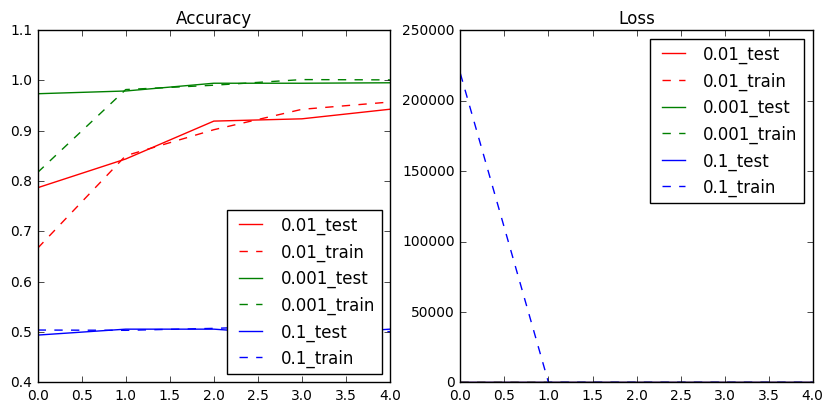

In [30]:
plot_results(results_lr, dict(zip(results_lr.keys(), ['r','g','b'])))

from the graphs above i found that the learning rate of 0.01 was optimal for getting the weights to converge since it acheives the highest accuracy and minimal loss quicker than other rates.

##### batch size

104batches [00:41,  2.97batches/s]                          
104batches [00:40,  2.84batches/s]                          
104batches [00:43,  3.94batches/s]                          
104batches [00:31,  3.67batches/s]                          
104batches [00:33,  3.94batches/s]                          


finished a model


52batches [00:48,  1.65batches/s]                          
52batches [00:29,  1.99batches/s]                          
52batches [00:37,  1.47batches/s]                          
52batches [00:37,  1.75batches/s]                          
52batches [00:32,  1.72batches/s]                          


finished a model


26batches [00:40,  1.63s/batches]                           
26batches [00:33,  1.27s/batches]                           
26batches [00:33,  1.25s/batches]                           
26batches [00:33,  1.19s/batches]                           
26batches [00:33,  1.22s/batches]                           


finished a model


13batches [00:32,  2.32s/batches]                            
13batches [00:30,  2.37s/batches]                            
13batches [00:31,  2.45s/batches]                            
13batches [00:31,  2.33s/batches]                            
13batches [00:34,  2.38s/batches]                            


finished a model


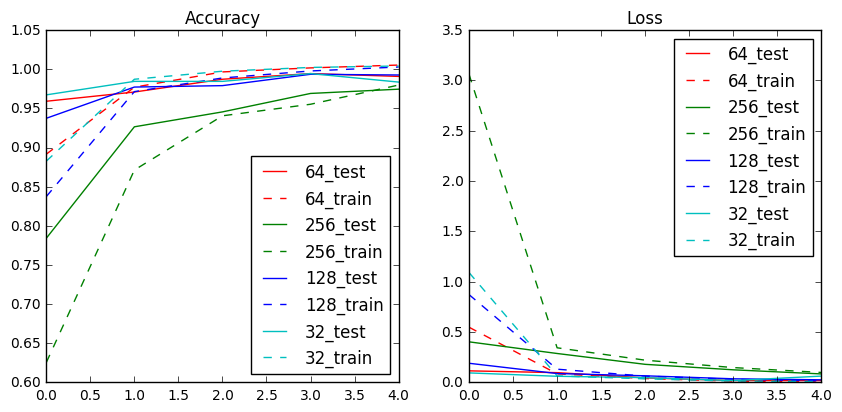

In [31]:
lr = 0.001
sigma = 0.1
hidden_nodes = 1024
classes= 2
search_epochs = 5
batch_sizes= [32, 64, 128, 256]
results_bs = {}

for batch_size in batch_sizes:
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    tf.reset_default_graph()
    with tf.Session() as sess:
        # setup tf graph
        (x , 
         x_reshaped, 
         y, 
         conv_output, 
         fc0,
         keep_prob,
         fc1, 
         y_, 
         cross_entropy, 
         loss_operation,
         optimizer, 
         training_operation, 
         correct_prediction, 
         accuracy_operation) = param_search_graph_setup(lr, hidden_nodes, sigma)

        # setup evaluation function
        def eval_data(dataset_features, dataset_labels, batch_size=batch_size):
            total_acc, total_loss = 0, 0
            num_examples = len(dataset_labels)
            sess = tf.get_default_session()
            dataset_feature_batcher = batch_generator(dataset_features, batch_size)
            dataset_label_batcher = batch_generator(dataset_labels, batch_size)
            for batch_x in dataset_feature_batcher:
                batch_size = len(batch_x)
                batch_y = next(dataset_label_batcher)
                batch_y = [binary_encode_label(y) for y in batch_y]
                loss, acc = sess.run([loss_operation, accuracy_operation], feed_dict={
                        x: batch_x, 
                        y: batch_y,
                        keep_prob: 1,
                    })
                total_acc += (acc * batch_size)
                total_loss += (loss * batch_size)
            return total_loss/num_examples, total_acc/num_examples

        sess.run(tf.global_variables_initializer())
        for i in range(search_epochs):
            train_X, train_y = shuffle_dataset(train_X, train_y)
            train_feature_batcher = batch_generator(train_X, batch_size)
            train_label_batcher = batch_generator(train_y, batch_size)
            n = 0
            train_accuracy_total = 0
            training_loss_total = 0
            for x_batch in tqdm(
                train_feature_batcher, 
                unit='batches', 
                total=train_X.shape[0]/ batch_size):

                y_batch = next(train_label_batcher)
                y_batch = [binary_encode_label(y) for y in y_batch]


                result, training_loss, training_accuracy=sess.run([training_operation, loss_operation, accuracy_operation], feed_dict={
                        x: x_batch,
                        y: y_batch,
                        keep_prob: 1
                })
                train_accuracy_total += (training_accuracy * batch_size)
                training_loss_total += (training_loss * batch_size)

                n += 1
            val_loss, val_acc = eval_data(test_X, test_y)
            train_losses.append(training_loss_total/train_X.shape[0])
            train_accuracies.append(train_accuracy_total/train_X.shape[0])
            test_losses.append(val_loss)
            test_accuracies.append(val_acc)
    
    print("finished a model")
    
    results_bs[str(batch_size)] = {}
    results_bs[str(batch_size)]['train_loss'] = train_losses
    results_bs[str(batch_size)]['train_acc'] = train_accuracies
    results_bs[str(batch_size)]['test_loss'] = test_losses
    results_bs[str(batch_size)]['test_acc'] = test_accuracies

plot_results(results_bs, dict(zip(results_bs.keys(), ['r','g','b', 'c'])))

from the graphs above i found that the batch size of 64 was optimal for getting the weights to converge since it acheives the highest accuracy and minimal loss quicker than other rates.

##### weight initialization

52batches [00:43,  1.58batches/s]                          
52batches [00:39,  1.70batches/s]                          
52batches [00:37,  1.73batches/s]                          
52batches [00:36,  1.49batches/s]                          
52batches [00:34,  2.00batches/s]                          


finished a model


52batches [00:32,  1.68batches/s]                          
52batches [00:44,  1.26s/batches]                          
52batches [00:49,  1.33batches/s]                          
52batches [00:51,  1.02s/batches]                          
52batches [00:51,  1.12batches/s]                          


finished a model


52batches [00:54,  1.06batches/s]                          
52batches [00:48,  1.25batches/s]                          
52batches [00:46,  1.20batches/s]                          
52batches [00:50,  1.14batches/s]                          
52batches [00:49,  1.06batches/s]                          


finished a model


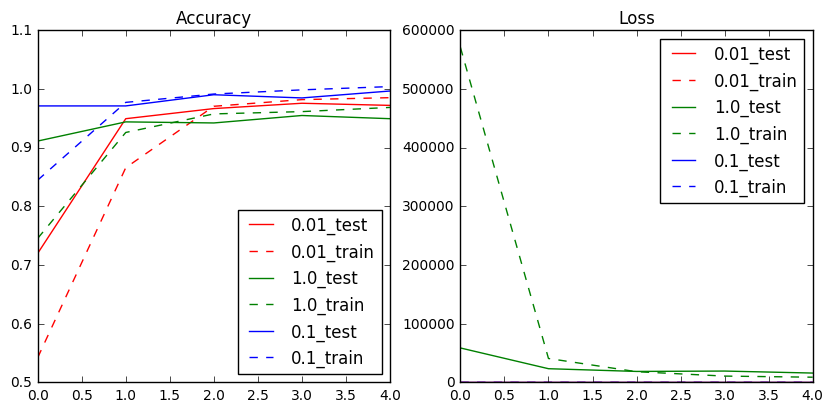

In [33]:
lr = 0.001
sigmas = [0.1, 0.01, 1.0]
hidden_nodes = 1024
classes= 2
search_epochs = 5
batch_size= 64
results_sigma = {}

for sigma in sigmas:
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    tf.reset_default_graph()
    with tf.Session() as sess:
        # setup tf graph
        (x , 
         x_reshaped, 
         y, 
         conv_output, 
         fc0,
         keep_prob,
         fc1, 
         y_, 
         cross_entropy, 
         loss_operation,
         optimizer, 
         training_operation, 
         correct_prediction, 
         accuracy_operation) = param_search_graph_setup(lr, hidden_nodes, sigma)

        # setup evaluation function
        def eval_data(dataset_features, dataset_labels, batch_size=batch_size):
            total_acc, total_loss = 0, 0
            num_examples = len(dataset_labels)
            sess = tf.get_default_session()
            dataset_feature_batcher = batch_generator(dataset_features, batch_size)
            dataset_label_batcher = batch_generator(dataset_labels, batch_size)
            for batch_x in dataset_feature_batcher:
                batch_size = len(batch_x)
                batch_y = next(dataset_label_batcher)
                batch_y = [binary_encode_label(y) for y in batch_y]
                loss, acc = sess.run([loss_operation, accuracy_operation], feed_dict={
                        x: batch_x, 
                        y: batch_y,
                        keep_prob: 1,
                    })
                total_acc += (acc * batch_size)
                total_loss += (loss * batch_size)
            return total_loss/num_examples, total_acc/num_examples

        sess.run(tf.global_variables_initializer())
        for i in range(search_epochs):
            train_X, train_y = shuffle_dataset(train_X, train_y)
            train_feature_batcher = batch_generator(train_X, batch_size)
            train_label_batcher = batch_generator(train_y, batch_size)
            n = 0
            train_accuracy_total = 0
            training_loss_total = 0
            for x_batch in tqdm(
                train_feature_batcher, 
                unit='batches', 
                total=train_X.shape[0]/ batch_size):

                y_batch = next(train_label_batcher)
                y_batch = [binary_encode_label(y) for y in y_batch]


                result, training_loss, training_accuracy=sess.run([training_operation, loss_operation, accuracy_operation], feed_dict={
                        x: x_batch,
                        y: y_batch,
                        keep_prob: 1
                })
                train_accuracy_total += (training_accuracy * batch_size)
                training_loss_total += (training_loss * batch_size)

                n += 1
            val_loss, val_acc = eval_data(test_X, test_y)
            train_losses.append(training_loss_total/train_X.shape[0])
            train_accuracies.append(train_accuracy_total/train_X.shape[0])
            test_losses.append(val_loss)
            test_accuracies.append(val_acc)
    
    print("finished a model")
    
    results_sigma[str(sigma)] = {}
    results_sigma[str(sigma)]['train_loss'] = train_losses
    results_sigma[str(sigma)]['train_acc'] = train_accuracies
    results_sigma[str(sigma)]['test_loss'] = test_losses
    results_sigma[str(sigma)]['test_acc'] = test_accuracies

plot_results(results_sigma, dict(zip(results_sigma.keys(), ['r','g','b'])))

from the graphs above i found that the standard deviation for weight initialization of 0.1 was optimal for getting the weights to converge since it acheives the highest accuracy and minimal loss quicker than other rates.

##### number of hidden nodes

52batches [00:52,  1.52batches/s]                          
52batches [00:44,  1.78batches/s]                          
52batches [00:31,  1.64batches/s]                          
52batches [00:32,  1.77batches/s]                          
52batches [00:32,  1.82batches/s]                          


finished a model


52batches [00:34,  1.58batches/s]                          
52batches [00:32,  1.78batches/s]                          
52batches [00:31,  1.81batches/s]                          
52batches [00:32,  1.76batches/s]                          
52batches [00:32,  1.80batches/s]                          


finished a model


52batches [00:37,  1.56batches/s]                          
52batches [00:36,  1.53batches/s]                          
52batches [00:36,  1.53batches/s]                          
52batches [00:36,  1.56batches/s]                          
52batches [00:36,  1.56batches/s]                          


finished a model


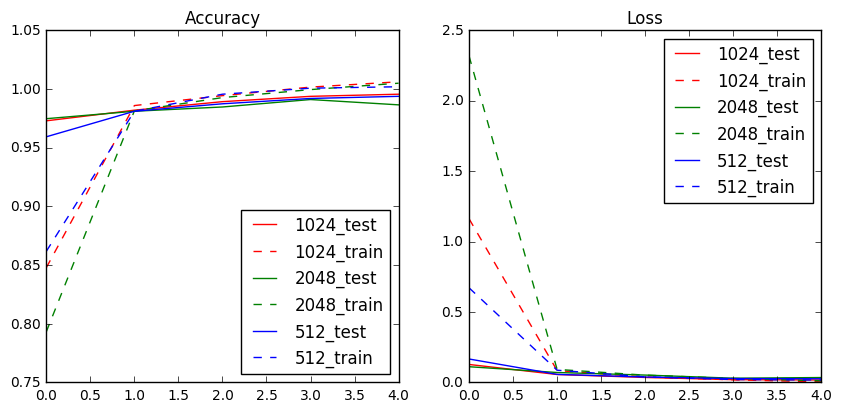

In [34]:
lr = 0.001
sigma = 0.1
n_hidden_nodes = [512, 1024, 2048]
classes= 2
search_epochs = 5
batch_size= 64
results_nodes = {}

for hidden_nodes in n_hidden_nodes:
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    tf.reset_default_graph()
    with tf.Session() as sess:
        # setup tf graph
        (x , 
         x_reshaped, 
         y, 
         conv_output, 
         fc0,
         keep_prob,
         fc1, 
         y_, 
         cross_entropy, 
         loss_operation,
         optimizer, 
         training_operation, 
         correct_prediction, 
         accuracy_operation) = param_search_graph_setup(lr, hidden_nodes, sigma)

        # setup evaluation function
        def eval_data(dataset_features, dataset_labels, batch_size=batch_size):
            total_acc, total_loss = 0, 0
            num_examples = len(dataset_labels)
            sess = tf.get_default_session()
            dataset_feature_batcher = batch_generator(dataset_features, batch_size)
            dataset_label_batcher = batch_generator(dataset_labels, batch_size)
            for batch_x in dataset_feature_batcher:
                batch_size = len(batch_x)
                batch_y = next(dataset_label_batcher)
                batch_y = [binary_encode_label(y) for y in batch_y]
                loss, acc = sess.run([loss_operation, accuracy_operation], feed_dict={
                        x: batch_x, 
                        y: batch_y,
                        keep_prob: 1,
                    })
                total_acc += (acc * batch_size)
                total_loss += (loss * batch_size)
            return total_loss/num_examples, total_acc/num_examples

        sess.run(tf.global_variables_initializer())
        for i in range(search_epochs):
            train_X, train_y = shuffle_dataset(train_X, train_y)
            train_feature_batcher = batch_generator(train_X, batch_size)
            train_label_batcher = batch_generator(train_y, batch_size)
            n = 0
            train_accuracy_total = 0
            training_loss_total = 0
            for x_batch in tqdm(
                train_feature_batcher, 
                unit='batches', 
                total=train_X.shape[0]/ batch_size):

                y_batch = next(train_label_batcher)
                y_batch = [binary_encode_label(y) for y in y_batch]


                result, training_loss, training_accuracy=sess.run([training_operation, loss_operation, accuracy_operation], feed_dict={
                        x: x_batch,
                        y: y_batch,
                        keep_prob: 1
                })
                train_accuracy_total += (training_accuracy * batch_size)
                training_loss_total += (training_loss * batch_size)

                n += 1
            val_loss, val_acc = eval_data(test_X, test_y)
            train_losses.append(training_loss_total/train_X.shape[0])
            train_accuracies.append(train_accuracy_total/train_X.shape[0])
            test_losses.append(val_loss)
            test_accuracies.append(val_acc)
    
    print("finished a model")
    
    results_nodes[str(hidden_nodes)] = {}
    results_nodes[str(hidden_nodes)]['train_loss'] = train_losses
    results_nodes[str(hidden_nodes)]['train_acc'] = train_accuracies
    results_nodes[str(hidden_nodes)]['test_loss'] = test_losses
    results_nodes[str(hidden_nodes)]['test_acc'] = test_accuracies
    
plot_results(results_nodes, dict(zip(results_nodes.keys(), ['r','g','b'])))

i found that keeping either 1024 or 512 nodes seems to give similar results. this suggested that 512 nodes is sufficient complexity to learn to solve the problem.

##### dropout 

52batches [00:37,  1.55batches/s]                          
52batches [00:36,  1.56batches/s]                          
52batches [00:36,  1.56batches/s]                          
52batches [00:36,  1.59batches/s]                          
52batches [00:36,  1.55batches/s]                          


finished a model


52batches [00:39,  1.68batches/s]                          
52batches [00:37,  1.73batches/s]                          
52batches [00:37,  1.63batches/s]                          
52batches [00:43,  1.24batches/s]                          
52batches [00:45,  1.46batches/s]                          


finished a model


52batches [00:44,  1.50batches/s]                          
52batches [00:36,  1.63batches/s]                          
52batches [00:34,  1.63batches/s]                          
52batches [00:34,  1.64batches/s]                          
52batches [00:34,  1.66batches/s]                          


finished a model


52batches [00:34,  1.69batches/s]                          
52batches [00:35,  1.61batches/s]                          
52batches [00:34,  1.56batches/s]                          
52batches [00:35,  1.61batches/s]                          
52batches [00:42,  1.50batches/s]                          


finished a model


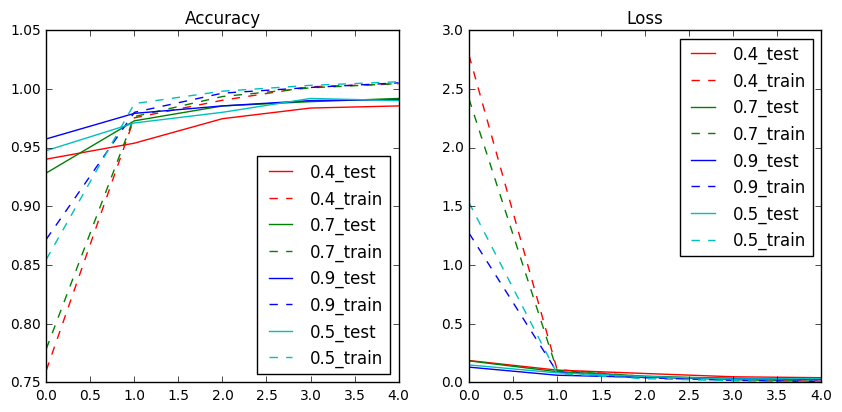

In [35]:
lr = 0.001
sigma = 0.1
n_hidden_nodes = 1024
classes= 2
search_epochs = 5
batch_size= 64
results_dropout = {}
dropouts = [0.9, 0.7, 0.5, 0.4]
for dropout in dropouts:
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    tf.reset_default_graph()
    with tf.Session() as sess:
        # setup tf graph
        (x , 
         x_reshaped, 
         y, 
         conv_output, 
         fc0,
         keep_prob,
         fc1, 
         y_, 
         cross_entropy, 
         loss_operation,
         optimizer, 
         training_operation, 
         correct_prediction, 
         accuracy_operation) = param_search_graph_setup(lr, hidden_nodes, sigma)

        # setup evaluation function
        def eval_data(dataset_features, dataset_labels, batch_size=batch_size):
            total_acc, total_loss = 0, 0
            num_examples = len(dataset_labels)
            sess = tf.get_default_session()
            dataset_feature_batcher = batch_generator(dataset_features, batch_size)
            dataset_label_batcher = batch_generator(dataset_labels, batch_size)
            for batch_x in dataset_feature_batcher:
                batch_size = len(batch_x)
                batch_y = next(dataset_label_batcher)
                batch_y = [binary_encode_label(y) for y in batch_y]
                loss, acc = sess.run([loss_operation, accuracy_operation], feed_dict={
                        x: batch_x, 
                        y: batch_y,
                        keep_prob: dropout,
                    })
                total_acc += (acc * batch_size)
                total_loss += (loss * batch_size)
            return total_loss/num_examples, total_acc/num_examples

        sess.run(tf.global_variables_initializer())
        for i in range(search_epochs):
            train_X, train_y = shuffle_dataset(train_X, train_y)
            train_feature_batcher = batch_generator(train_X, batch_size)
            train_label_batcher = batch_generator(train_y, batch_size)
            n = 0
            train_accuracy_total = 0
            training_loss_total = 0
            for x_batch in tqdm(
                train_feature_batcher, 
                unit='batches', 
                total=train_X.shape[0]/ batch_size):

                y_batch = next(train_label_batcher)
                y_batch = [binary_encode_label(y) for y in y_batch]


                result, training_loss, training_accuracy=sess.run([training_operation, loss_operation, accuracy_operation], feed_dict={
                        x: x_batch,
                        y: y_batch,
                        keep_prob: 1
                })
                train_accuracy_total += (training_accuracy * batch_size)
                training_loss_total += (training_loss * batch_size)

                n += 1
            val_loss, val_acc = eval_data(test_X, test_y)
            train_losses.append(training_loss_total/train_X.shape[0])
            train_accuracies.append(train_accuracy_total/train_X.shape[0])
            test_losses.append(val_loss)
            test_accuracies.append(val_acc)
    
    print("finished a model")
    
    results_dropout[str(dropout)] = {}
    results_dropout[str(dropout)]['train_loss'] = train_losses
    results_dropout[str(dropout)]['train_acc'] = train_accuracies
    results_dropout[str(dropout)]['test_loss'] = test_losses
    results_dropout[str(dropout)]['test_acc'] = test_accuracies

plot_results(results_dropout, dict(zip(results_dropout.keys(), ['r','g','b', 'c'])))

I found that using a dropout of 0.5 was better that increasing or decreasing the dropout parameter.

##### evaluation of test dataset
in the section below i evaluated the final model on the test dataset. The accuracy of the model seems quite high at approximately 95%. I also used a confusion matrix for the predictions to see which classes are misidentified.

In [94]:
image_set = np.asarray(X_test)
label_set = y_test
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./models/'))
    pred_label = tf.argmax(y_, 1)
    preds = []
    dataset_feature_batcher = batch_generator(image_set, batch_size)
    dataset_label_batcher = batch_generator(label_set, batch_size)
    for batch_x in tqdm(
            dataset_feature_batcher, 
            unit='batches', 
            total=X_test.shape[0]/ batch_size):
        batch_size = len(batch_x)
        batch_y = next(dataset_label_batcher)
        batch_y = [encode_label(y) for y in batch_y]
        new_preds = sess.run(pred_label, feed_dict={
                x: batch_x,
                y: batch_y,
                keep_prob: 1
            })
        preds.extend(new_preds)

198batches [00:48,  4.83batches/s]                          


In [95]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(y_test, preds,)

In [101]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{0:.2f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Normalized confusion matrix


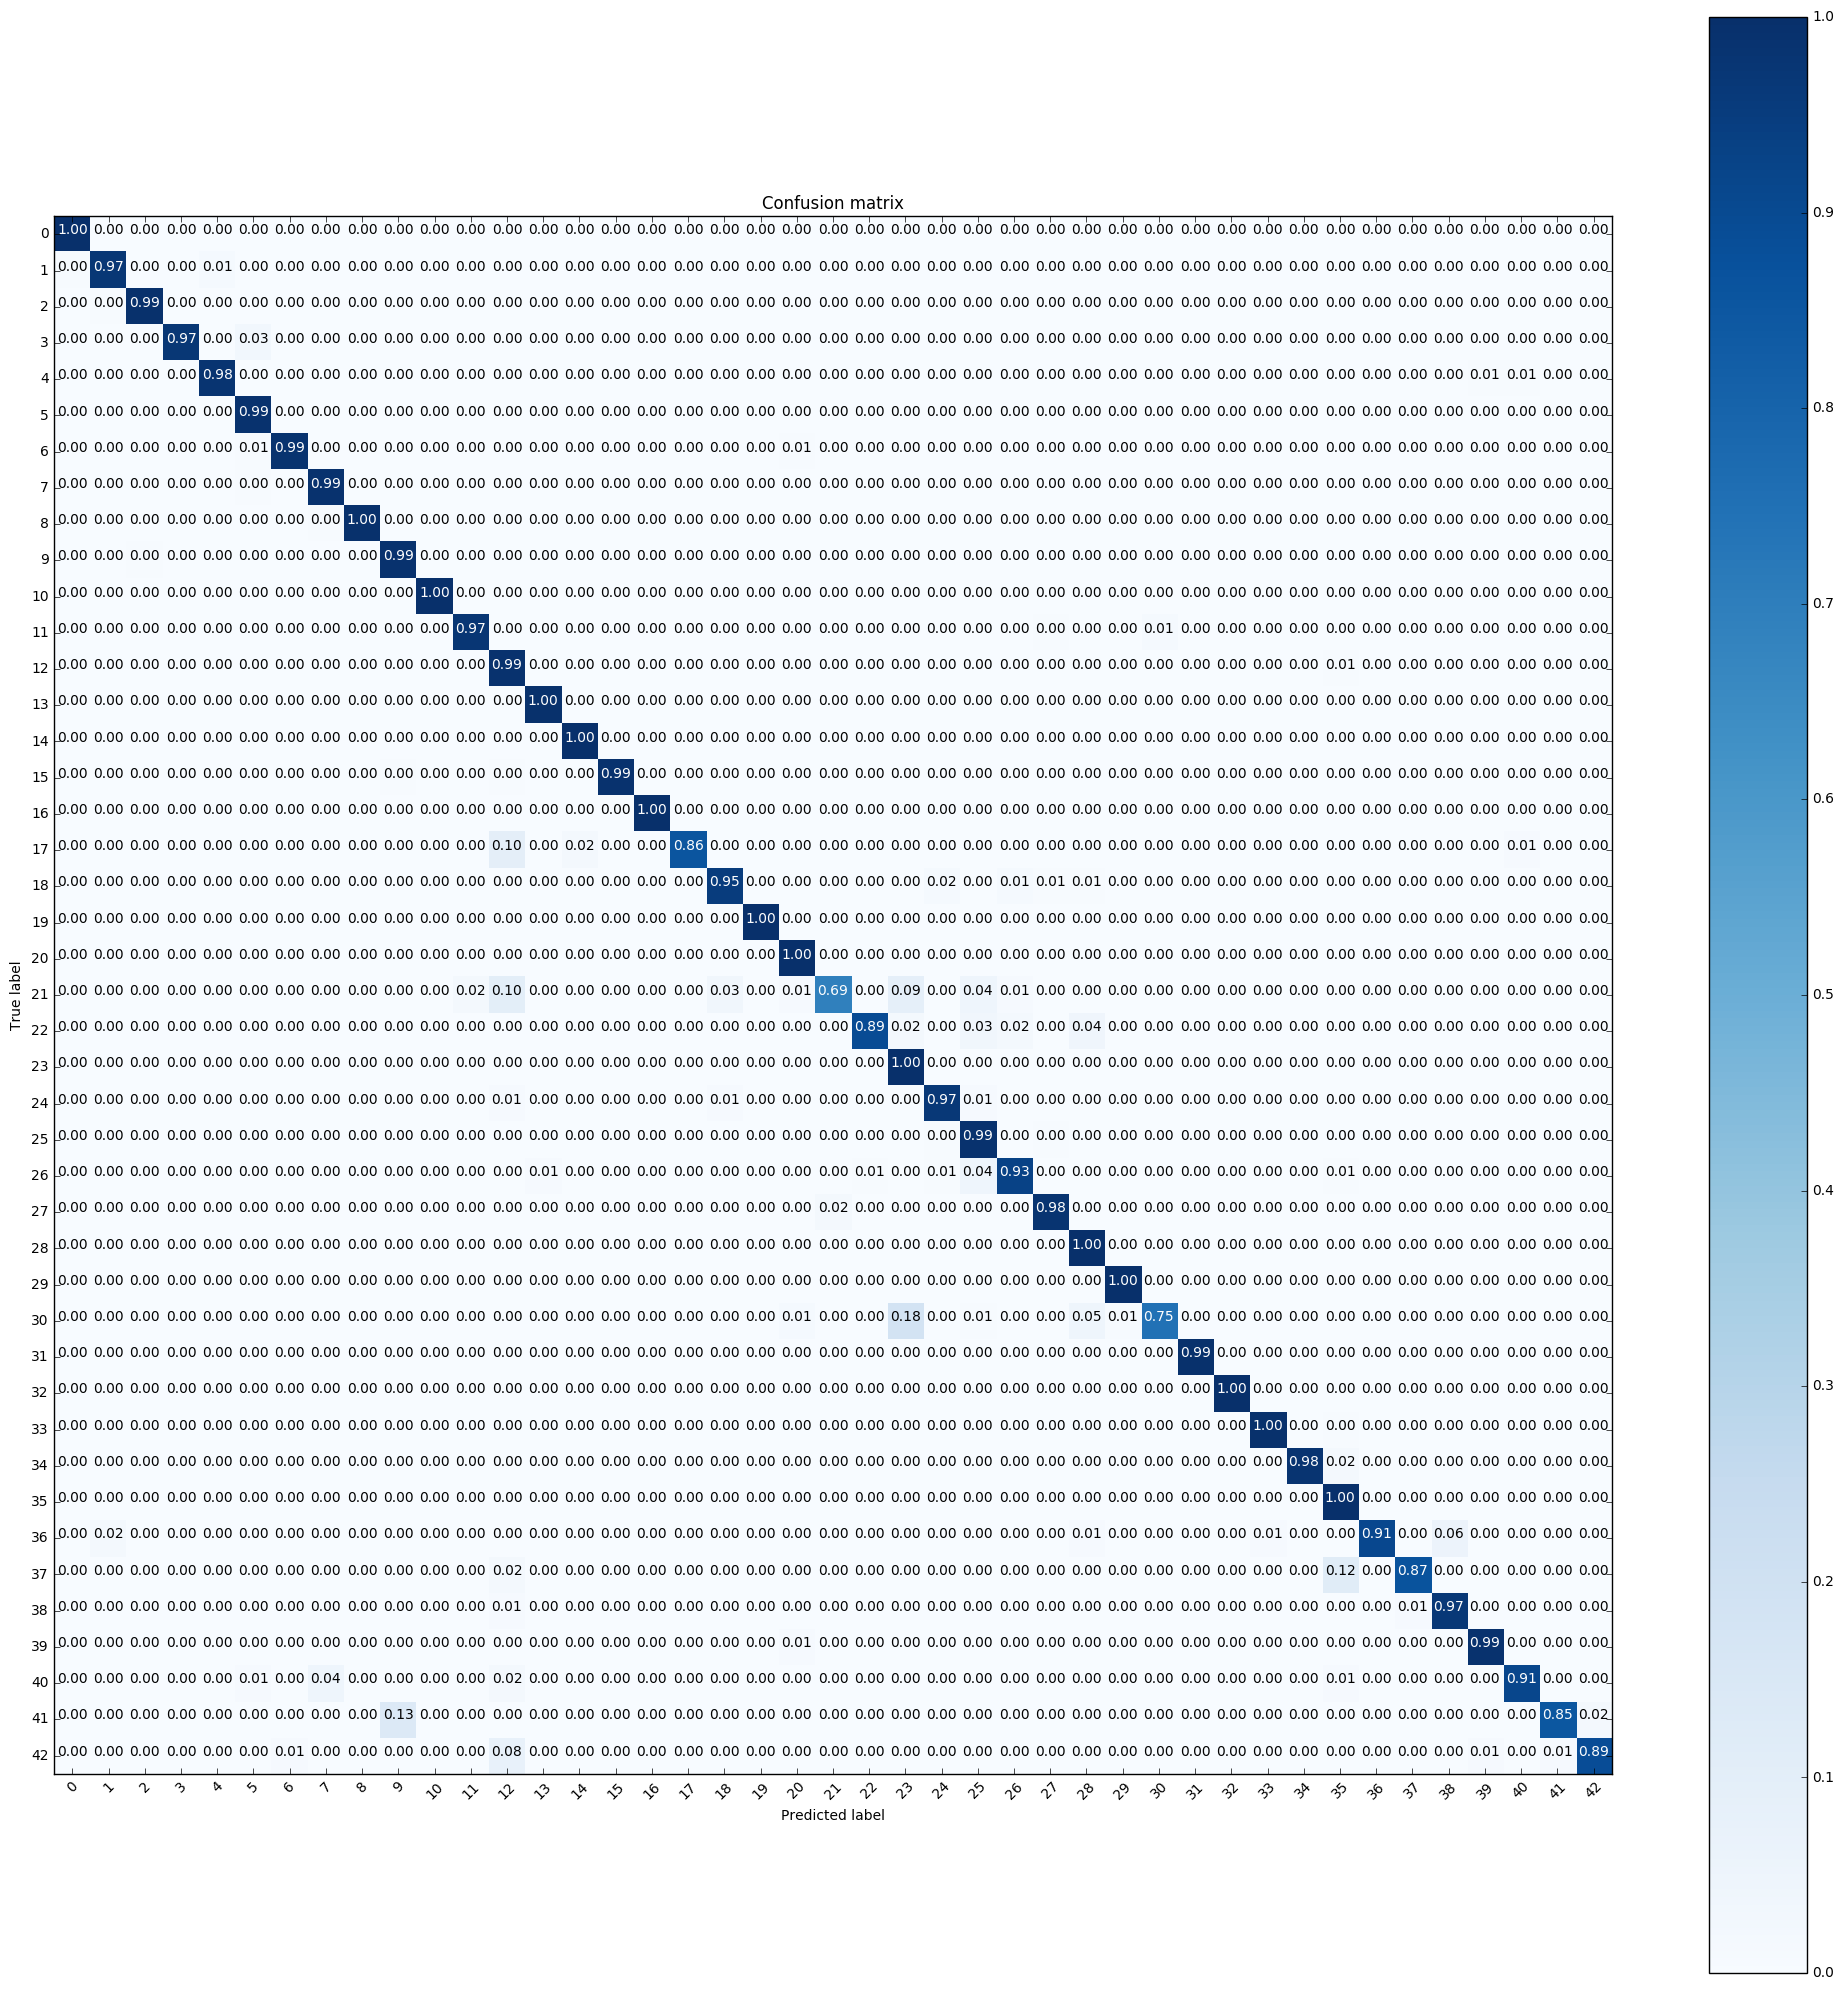

In [103]:
plt.figure(figsize=(20,20))
plot_confusion_matrix(cf, np.arange(43))

we find that the network has learnt quite well scoring around 96% on the final test set. even on the confusion matrix we see that the diagonals are generally above 0.9 which means it's able to sufficiently capture characteristics of each class.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

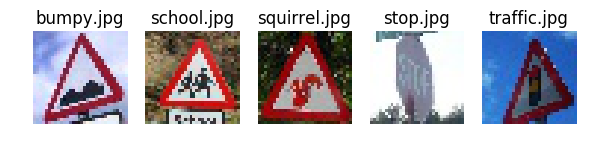

In [16]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import glob
image_files = glob.glob('test_images/*')
from matplotlib import gridspec
from matplotlib import pyplot as plt
import cv2
%matplotlib inline
figure = plt.figure(figsize=(7,5))
grid = gridspec.GridSpec(1, 5)
test_images = []
for i,filename in enumerate(image_files):
    ax = plt.subplot(grid[i])
    img= plt.imread(filename)
    test_images.append(img)
    plt.imshow(img, interpolation='nearest')
    ax.axis('off')
    ax.set_title(filename.split('/')[1])
    

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



In [22]:
import csv
labels = []
with open('signnames.csv') as csv_file:
    labelreader = csv.reader(csv_file)
    for label_id,label_class in labelreader:
            if label_class != 'SignName':
                labels.append(label_class)

In [28]:
processed_test_images = [preprocess_image(image) for image in test_images]

In [30]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./models/'))
    pred_label = tf.argmax(y_, 1)
    preds = sess.run(pred_label, feed_dict={
                x: processed_test_images,
                keep_prob: 1
            })

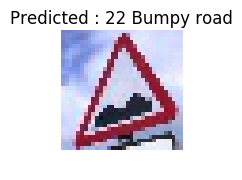

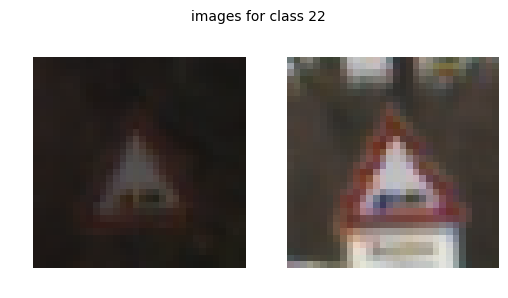

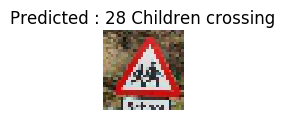

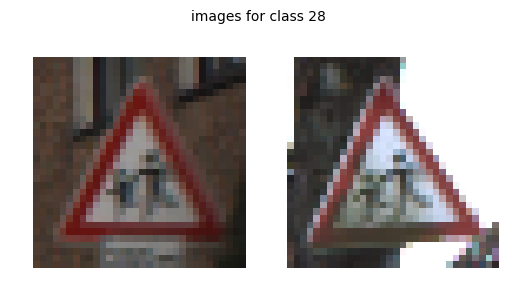

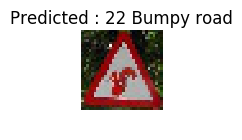

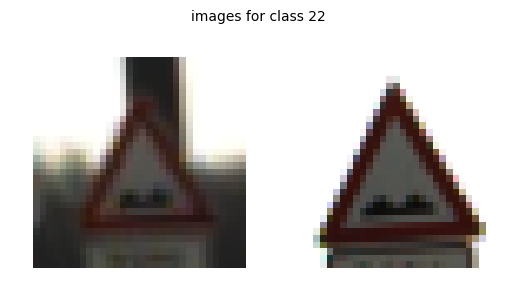

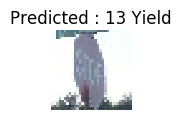

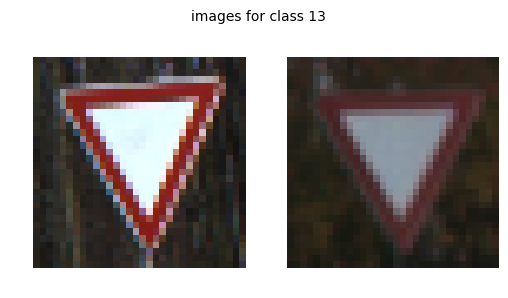

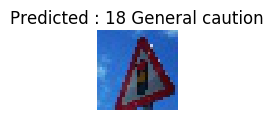

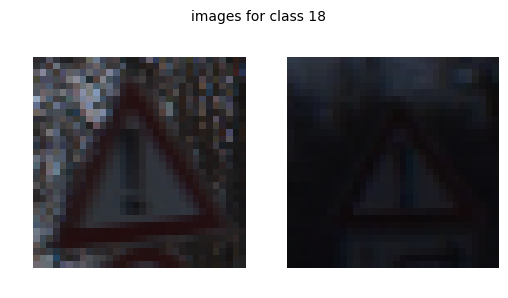

In [41]:
%matplotlib inline
figure = plt.figure(figsize=(9,5))
grid = gridspec.GridSpec(1, 5)
for i,filename in enumerate(image_files):
    ax = plt.subplot(grid[i])
    img= plt.imread(filename)
    test_images.append(img)
    plt.imshow(img, interpolation='nearest')
    ax.axis('off')
    class_id = preds[i]
    ax.set_title("Predicted : {} {}".format(class_id, labels[class_id]))
    
    plot_n_images_for_class(class_label=class_id, n=2)

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**
i found that the network acheives around 60% accuracy on the 5 new images. we see that the first 2 images are classified completely accurately. the third image is of a sign that wasnt present in the dataset but the network does a good job at approximating to a similar sign.
for the 4th image, the network gets it completely wrong and for the 5th image it gets it wrong but matches a class which looks similar

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [59]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./models/'))
    top_5 = tf.nn.top_k(tf.nn.softmax(y_), 5)
    top_5_preds = sess.run(top_5, feed_dict={
                x: processed_test_images,
                keep_prob: 1
            })

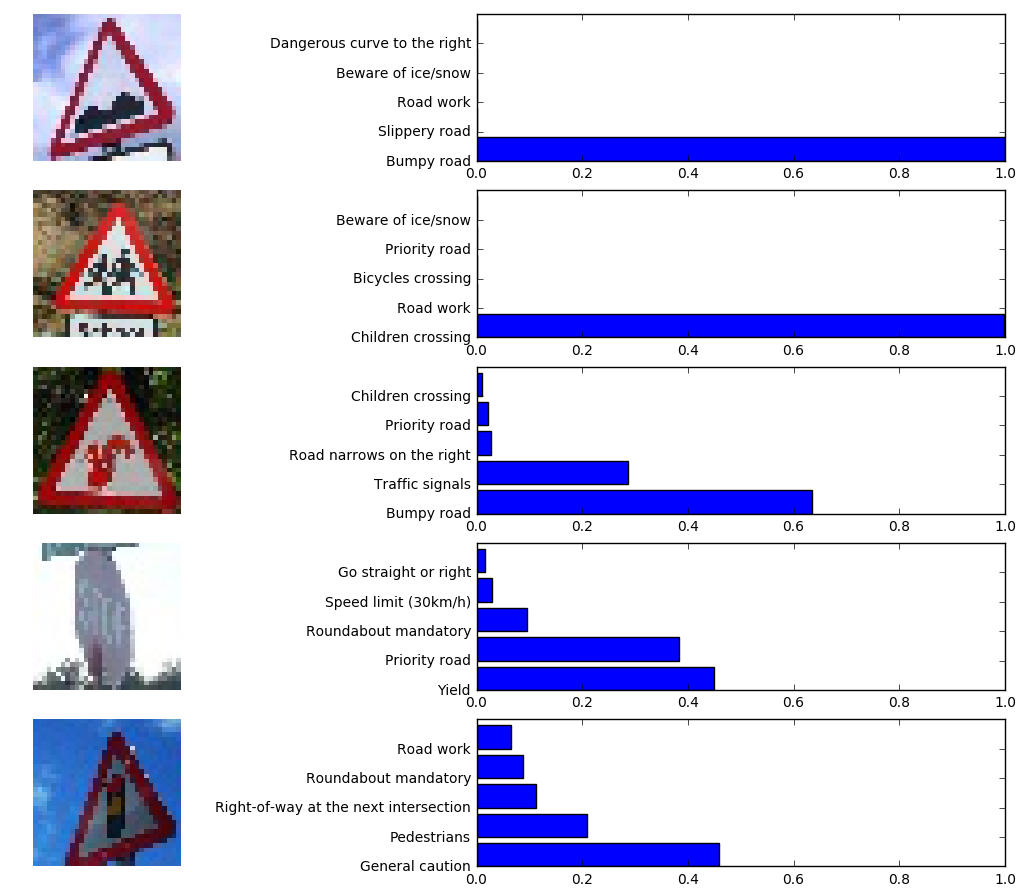

In [83]:
prediction_indices = top_5_preds.indices
pred_probs = top_5_preds.values
figure = plt.figure(figsize=(15 ,11))
grid = gridspec.GridSpec(5, 2)
labels = np.asarray(labels)
for i,filename in enumerate(image_files):
    ax = plt.subplot(grid[i*2])
    img= plt.imread(filename)
    test_images.append(img)
    plt.imshow(img, interpolation='nearest')
    ax.axis('off')
    probs = pred_probs[i]
    indices = labels[prediction_indices[i]]
    ax = plt.subplot(grid[i*2 + 1])
    
    ax.barh(np.arange(5), probs)
    ax.set_yticklabels(indices)
    ax.set_xlim(0,1.0)

**Answer:**

Visualing the top 5 softmax probibilities are quite revealing. 
We find that in the first 2 images, the network is almost completely certain about the class of the image and it is very accurate.
The third image is something the network has network has never seen but gives a 0.6 confidence of matching the bumpy road sign. interestingly the network is mainly predicting signs that are triangular in nature for this image.

In the 4th image the network is unable to predict and does not give a high confidence for any of the classes, it seems that it was unable to recognize the stop sign at the very tilted angle.

In the fifth image we again see that the network is unable to predict and is not confident at all about any of the predictions. this might be because the stop light signs on the training dataset have no black outline around the lights.


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.